In [1]:
import numpy as np
import torch
from torch import nn  
import math
import time 
import os  
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs

In [2]:
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray
root = '/tigress/cw55/work/2022_radi_nn' 

In [3]:
from get_data_sw_AM4_std import get_data_sw_AM4
######################################################
# common functions to split the training and test data
from NNRTMC_utils import NNRTMC_NN_sw, split_train_test_sample, \
draw_batches, data_std_normalization_sw,  return_exp_dir
torch.set_float32_matmul_precision('high')

from diag_utils import batch_index_sta_end, pred_NN_batch_sw,\
create_6tiles_sw,regrid_6tile2latlon

In [4]:
plt.rcParams['font.size'] = '6'

In [5]:
torch.cuda.set_device(0) # select gpu_id, default 0 means the first GPU
device = f'cuda:{torch.cuda.current_device()}'
# device = 'cpu'
######################################################
# set exp name and runs
Exp_name = [
    'ens_AM4std_sw_cs_LiH4W256Relu_EY'    ,
    'ens_AM4std_sw_all_LiH4W256Relu_EY'   ,
    'ens_AM4std_sw_cs_LiH4W256Relu_EN'    ,
    'ens_AM4std_sw_all_LiH4W256Relu_EN'   ,
] 
sky_cond = {
    'ens_AM4std_sw_cs_LiH4W256Relu_EY'    : 'cs',
    'ens_AM4std_sw_all_LiH4W256Relu_EY'   : 'all',
    'ens_AM4std_sw_cs_LiH4W256Relu_EN'    : 'cs',
    'ens_AM4std_sw_all_LiH4W256Relu_EN'   : 'all',
}
work_dir = root+'/work/' 
# file list AM4 runs 
filelist = [f'/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/'+
            f'HISTORY/20000101.atmos_8xdaily.tile{_}.nc' for _ in range(1,7)] 
hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
A_k = hybrid_p_sigma_para.ak.values[None,:]
B_k = hybrid_p_sigma_para.bk.values[None,:] 

In [6]:
month_sel = None
day_sel = [15,18,21,24,27]  #test

# Plot Loss

In [7]:
ensemble_size = 2 
loss_array = {}
for mo in Exp_name:
    loss_array[mo] = []
    for ei in range(ensemble_size):
        ######################################################
        # load restart file
        run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
        # load restart file
        PATH_last =  exp_dir+f'/model{ei}_restart.{run_num-1:02d}.pth'
        restart_data = torch.load(PATH_last)  # load exist results and restart training
        print(f'load: {PATH_last}')
        # read training dataset, nor_para, model parameteres
        loss_array[mo].append(restart_data['loss_array'])

load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/model0_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/model1_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_all_LiH4W256Relu_EY/model0_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_all_LiH4W256Relu_EY/model1_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EN/model0_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EN/model1_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_all_LiH4W256Relu_EN/model0_restart.03.pth
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_all_LiH4W256Relu_EN/model1_restart.03.pth


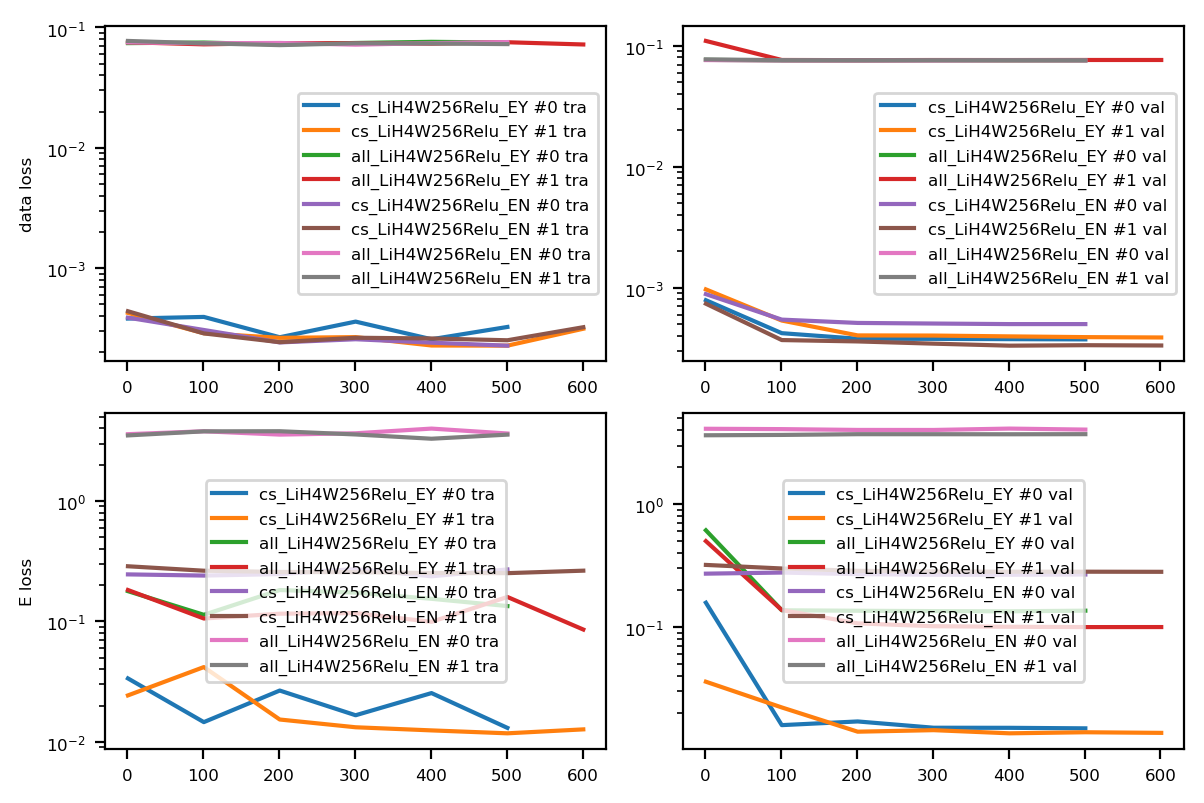

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,4),dpi=200, tight_layout=True)  
axs = axs.flatten()
for mo in Exp_name:
    for ei in range(ensemble_size):
        epochs  = loss_array[mo][ei][0]
        LD_tra  = loss_array[mo][ei][1]
        LE_tra  = loss_array[mo][ei][2]
        LD_val  = loss_array[mo][ei][3]
        LE_val  = loss_array[mo][ei][4]
        axs[0].plot(epochs,LD_tra, label = f'{mo[14:]} #{ei} tra')
        axs[1].plot(epochs,LD_val, label = f'{mo[14:]} #{ei} val')
        axs[2].plot(epochs,LE_tra, label = f'{mo[14:]} #{ei} tra')
        axs[3].plot(epochs,LE_val, label = f'{mo[14:]} #{ei} val')
for ax in axs:
    ax.set_yscale('log')
    ax.legend()
axs[0].set_ylabel('data loss')
axs[2].set_ylabel('E loss')
fig.show()

In [9]:
for mo in Exp_name:
    for ei in range(ensemble_size):
        epochs  = loss_array[mo][ei][0]
        LD_tra  = loss_array[mo][ei][1]
        LE_tra  = loss_array[mo][ei][2]
        LD_val  = loss_array[mo][ei][3]
        LE_val  = loss_array[mo][ei][4]
        print(mo)
        for epi,ep in enumerate(epochs):
            print(f'{ep:4.0f} tra {LD_tra[epi]:8.2e} {LE_tra[epi]:8.2e} val {LD_val[epi]:8.2e} {LE_val[epi]:8.2e} ')

ens_AM4std_sw_cs_LiH4W256Relu_EY
   1 tra 3.80e-04 3.36e-02 val 7.89e-04 1.57e-01 
 101 tra 3.93e-04 1.46e-02 val 4.21e-04 1.58e-02 
 201 tra 2.66e-04 2.66e-02 val 3.79e-04 1.70e-02 
 301 tra 3.59e-04 1.66e-02 val 3.78e-04 1.51e-02 
 401 tra 2.56e-04 2.54e-02 val 3.76e-04 1.50e-02 
 501 tra 3.24e-04 1.30e-02 val 3.74e-04 1.49e-02 
ens_AM4std_sw_cs_LiH4W256Relu_EY
   1 tra 4.24e-04 2.43e-02 val 9.69e-04 3.57e-02 
 101 tra 2.87e-04 4.17e-02 val 5.36e-04 2.21e-02 
 201 tra 2.63e-04 1.53e-02 val 4.04e-04 1.40e-02 
 301 tra 2.67e-04 1.32e-02 val 4.03e-04 1.44e-02 
 401 tra 2.27e-04 1.24e-02 val 3.96e-04 1.36e-02 
 501 tra 2.27e-04 1.18e-02 val 3.91e-04 1.38e-02 
 601 tra 3.13e-04 1.27e-02 val 3.88e-04 1.37e-02 
ens_AM4std_sw_all_LiH4W256Relu_EY
   1 tra 7.41e-02 1.78e-01 val 7.65e-02 6.13e-01 
 101 tra 7.49e-02 1.13e-01 val 7.56e-02 1.37e-01 
 201 tra 7.23e-02 1.82e-01 val 7.56e-02 1.35e-01 
 301 tra 7.43e-02 1.73e-01 val 7.59e-02 1.34e-01 
 401 tra 7.59e-02 1.54e-01 val 7.57e-02 1.34e-01 


## load model

In [10]:
ensemble_size = 2
NN_model = {} 

for mo in Exp_name:
    NN_model[mo] = []
    for ei in range(ensemble_size):
        ######################################################
        run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
        # load restart file
        PATH_last =  exp_dir+f'/model{ei}_restart.{run_num-1:02d}.pth'
        restart_data = torch.load(PATH_last)  # load exist results and restart training
        print(f'load: {PATH_last}')
        # read training dataset, nor_para, model parameteres
        nor_para = restart_data['nor_para']
        model_state_dict = restart_data['model_state_dict']
        nn_struc_name = list(restart_data['model_state_dict'].keys())
        input_size  = restart_data['model_state_dict'][nn_struc_name[0]].shape[1]
        output_size = restart_data['model_state_dict'][nn_struc_name[-1]].shape[0]
        hidden_layer_width = restart_data['model_state_dict'][nn_struc_name[0]].shape[0]
        print(input_size, output_size, hidden_layer_width,) 
        # initialize model 
        nn_model_ei = NNRTMC_NN_sw(device, nor_para, A_k, B_k, input_size, output_size, hidden_layer_width, model_state_dict)  
        NN_model[mo].append(nn_model_ei)

load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/model0_restart.03.pth
106 36 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/model1_restart.03.pth
106 36 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_all_LiH4W256Relu_EY/model0_restart.03.pth
370 36 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_all_LiH4W256Relu_EY/model1_restart.03.pth
370 36 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EN/model0_restart.03.pth
106 36 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EN/model1_restart.03.pth
106 36 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_all_LiH4W256Relu_EN/model0_restart.03.pth
370 36 256
load: /tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_all_LiH4W256Relu_EN/model1_restart.03.pth
370 36 256


In [11]:
# %%time  
recalculate = False
recalculate = True
ds_regrid = {} 

for mo in Exp_name: 
    ds_regrid[mo] = [] 
    if (recalculate == True) :
    # read data
        input_array_ori, output_array_ori, rsdt_array_ori, ds_coords = \
        get_data_sw_AM4(filelist, condition=sky_cond[mo], 
                        month_sel = month_sel, day_sel = day_sel, return_coords=True) 
    for ei in range(ensemble_size):
        run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
        NN_output_name = f'NN_{ei}_20000101.fluxes_test' 
        if (recalculate == True) :
        # pred with NN and regrid to lat lon grid.
            nor_para = NN_model[mo][ei].nor_para
            nor_para = {key: value.to('cpu').numpy() for key, value in nor_para.items()} 
            # normalize data via saved nor_para in restart file
            nor_para, input_array, output_array, rsdt_array, day_ind  \
            = data_std_normalization_sw(input_array_ori, output_array_ori, rsdt_array_ori, nor_para, remove_night=False)

            # try NN on test dataset  
            predi, eng_err = pred_NN_batch_sw(input_array, output_array, rsdt_array, NN_model[mo][ei], nor_para, device)
            error = predi - output_array_ori*rsdt_array_ori[:,None]
            predi[:,3:] = predi[:,3:]*86400 # HR K/s >> K/day
            error[:,3:] = error[:,3:]*86400 # HR K/s >> K/day 
            # create 6-tile files for output and regrid 
            subprocess.run([f'mkdir -p {exp_dir}/NN_pred'], shell=True, check=True)
            var_list = create_6tiles_sw(ds_coords, predi, error, eng_err,  exp_dir, NN_output_name)
            del predi, error, eng_err
            del input_array, output_array, rsdt_array, day_ind
            regrid_file_path = regrid_6tile2latlon(var_list, exp_dir, root, NN_output_name)
        regrid_file_path = exp_dir+f'/NN_pred/{NN_output_name}.nc'
        print(regrid_file_path)
        # open regridded file
        with  xr.open_dataset(regrid_file_path) as ds:
            ds_regrid[mo].append(ds.load().rename({'grid_yt':'lat', 'grid_xt':'lon'}))


Data files:
['/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile1.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile2.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile3.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile4.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile5.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile6.nc']
Data selection:
    Month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 
    Day: [15, 18, 21, 24, 27] 
Reading data... 0 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


1 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


2 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


3 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


4 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


5 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)



Read data done. Use time:  791s
Total data size: 26542080
Creating 6 tiles ...  Done.
Calling fregrid in subshell ...   Done.
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/NN_pred/NN_0_20000101.fluxes_test.nc
Total data size: 26542080
Creating 6 tiles ...  Done.
Calling fregrid in subshell ...   Done.
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/NN_pred/NN_1_20000101.fluxes_test.nc
Data files:
['/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile1.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile2.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile3.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile4.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


1 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


2 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


3 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


4 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


5 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)



Read data done. Use time:  1145s
Total data size: 26542080
Creating 6 tiles ...  Done.
Calling fregrid in subshell ...   Done.
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_all_LiH4W256Relu_EY/NN_pred/NN_0_20000101.fluxes_test.nc
Total data size: 26542080
Creating 6 tiles ...  Done.
Calling fregrid in subshell ...   Done.
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_all_LiH4W256Relu_EY/NN_pred/NN_1_20000101.fluxes_test.nc
Data files:
['/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile1.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile2.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile3.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile4.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


1 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


2 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


3 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


4 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


5 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)



Read data done. Use time:  718s
Total data size: 26542080
Creating 6 tiles ...  Done.
Calling fregrid in subshell ...   Done.
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EN/NN_pred/NN_0_20000101.fluxes_test.nc
Total data size: 26542080
Creating 6 tiles ...  Done.
Calling fregrid in subshell ...   Done.
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EN/NN_pred/NN_1_20000101.fluxes_test.nc
Data files:
['/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile1.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile2.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile3.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_768PE/HISTORY/20000101.atmos_8xdaily.tile4.nc', '/scratch/gpfs/cw55/AM4/work/CTL2000_train_y2000_stellarcpu_intelmpi_22_

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


1 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


2 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


3 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


4 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)


5 

/tigress/cw55/work/2022_radi_nn/NN_AM4/get_data_sw_AM4_std.py:71: RuntimeWarning: divide by zero encountered in true_divide
  rsdt_r = np.where(np.isclose(rsdt,0,rtol=1e-05, atol=1e-1,), 0, 1/rsdt)



Read data done. Use time:  659s
Total data size: 26542080
Creating 6 tiles ...  Done.
Calling fregrid in subshell ...   Done.
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_all_LiH4W256Relu_EN/NN_pred/NN_0_20000101.fluxes_test.nc
Total data size: 26542080
Creating 6 tiles ...  Done.
Calling fregrid in subshell ...   Done.
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_all_LiH4W256Relu_EN/NN_pred/NN_1_20000101.fluxes_test.nc


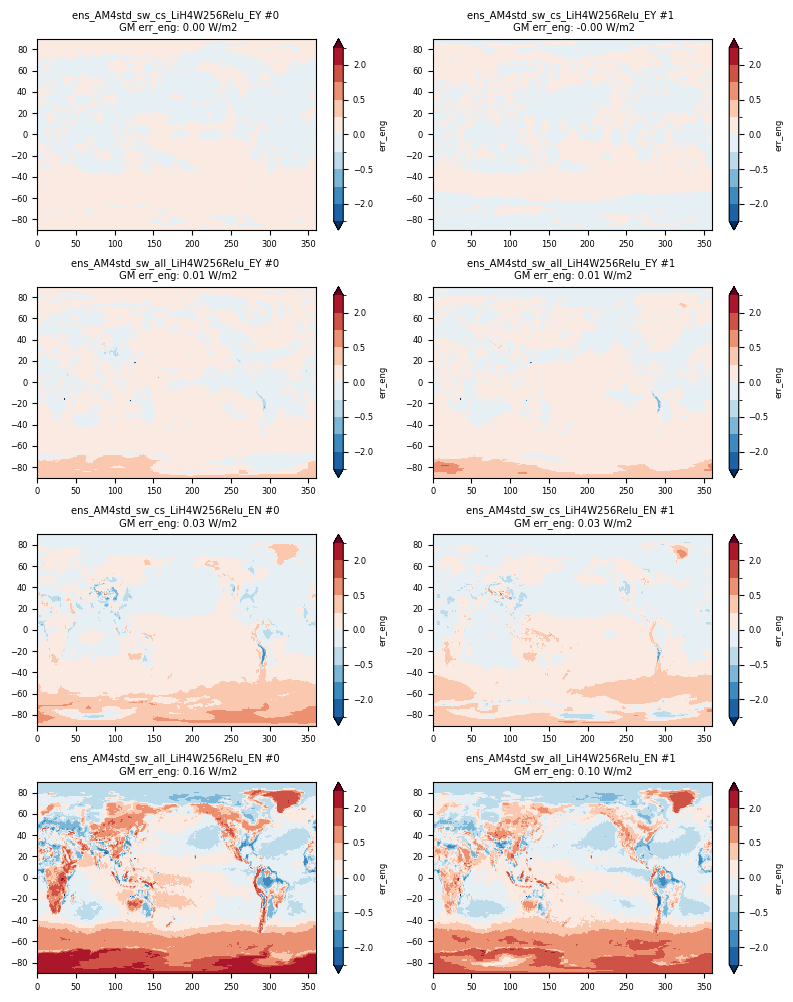

In [12]:
fig, axs = plt.subplots(nrows=2*ensemble_size,ncols=2,figsize=(8,5*ensemble_size),dpi=100)
axs = axs.flatten() 
for i, mo in enumerate(Exp_name):
    for ei in range(ensemble_size):
        ds_plot = ds_regrid[mo][ei]
        var_name = 'err_eng'
        level = np.array([-4,-2,-1,-0.5,-0.2,0,0.2,0.5,1,2,4 ])
        # level = np.arange(-5,5.1,0.5)
        # if sky_cond[mo] == 'all':  level = level*2
        ax=axs[i*ensemble_size+ei]
        da = ds_plot[var_name].mean('time')
        da.plot(ax=ax, levels=level, extend='both') 
        ax.set_title(f'{mo} #{ei} \n GM err_eng: {global_mean_xarray(da).values:4.2f} W/m2') 
        ax.set(xlabel=None,ylabel=None) 
fig.tight_layout()

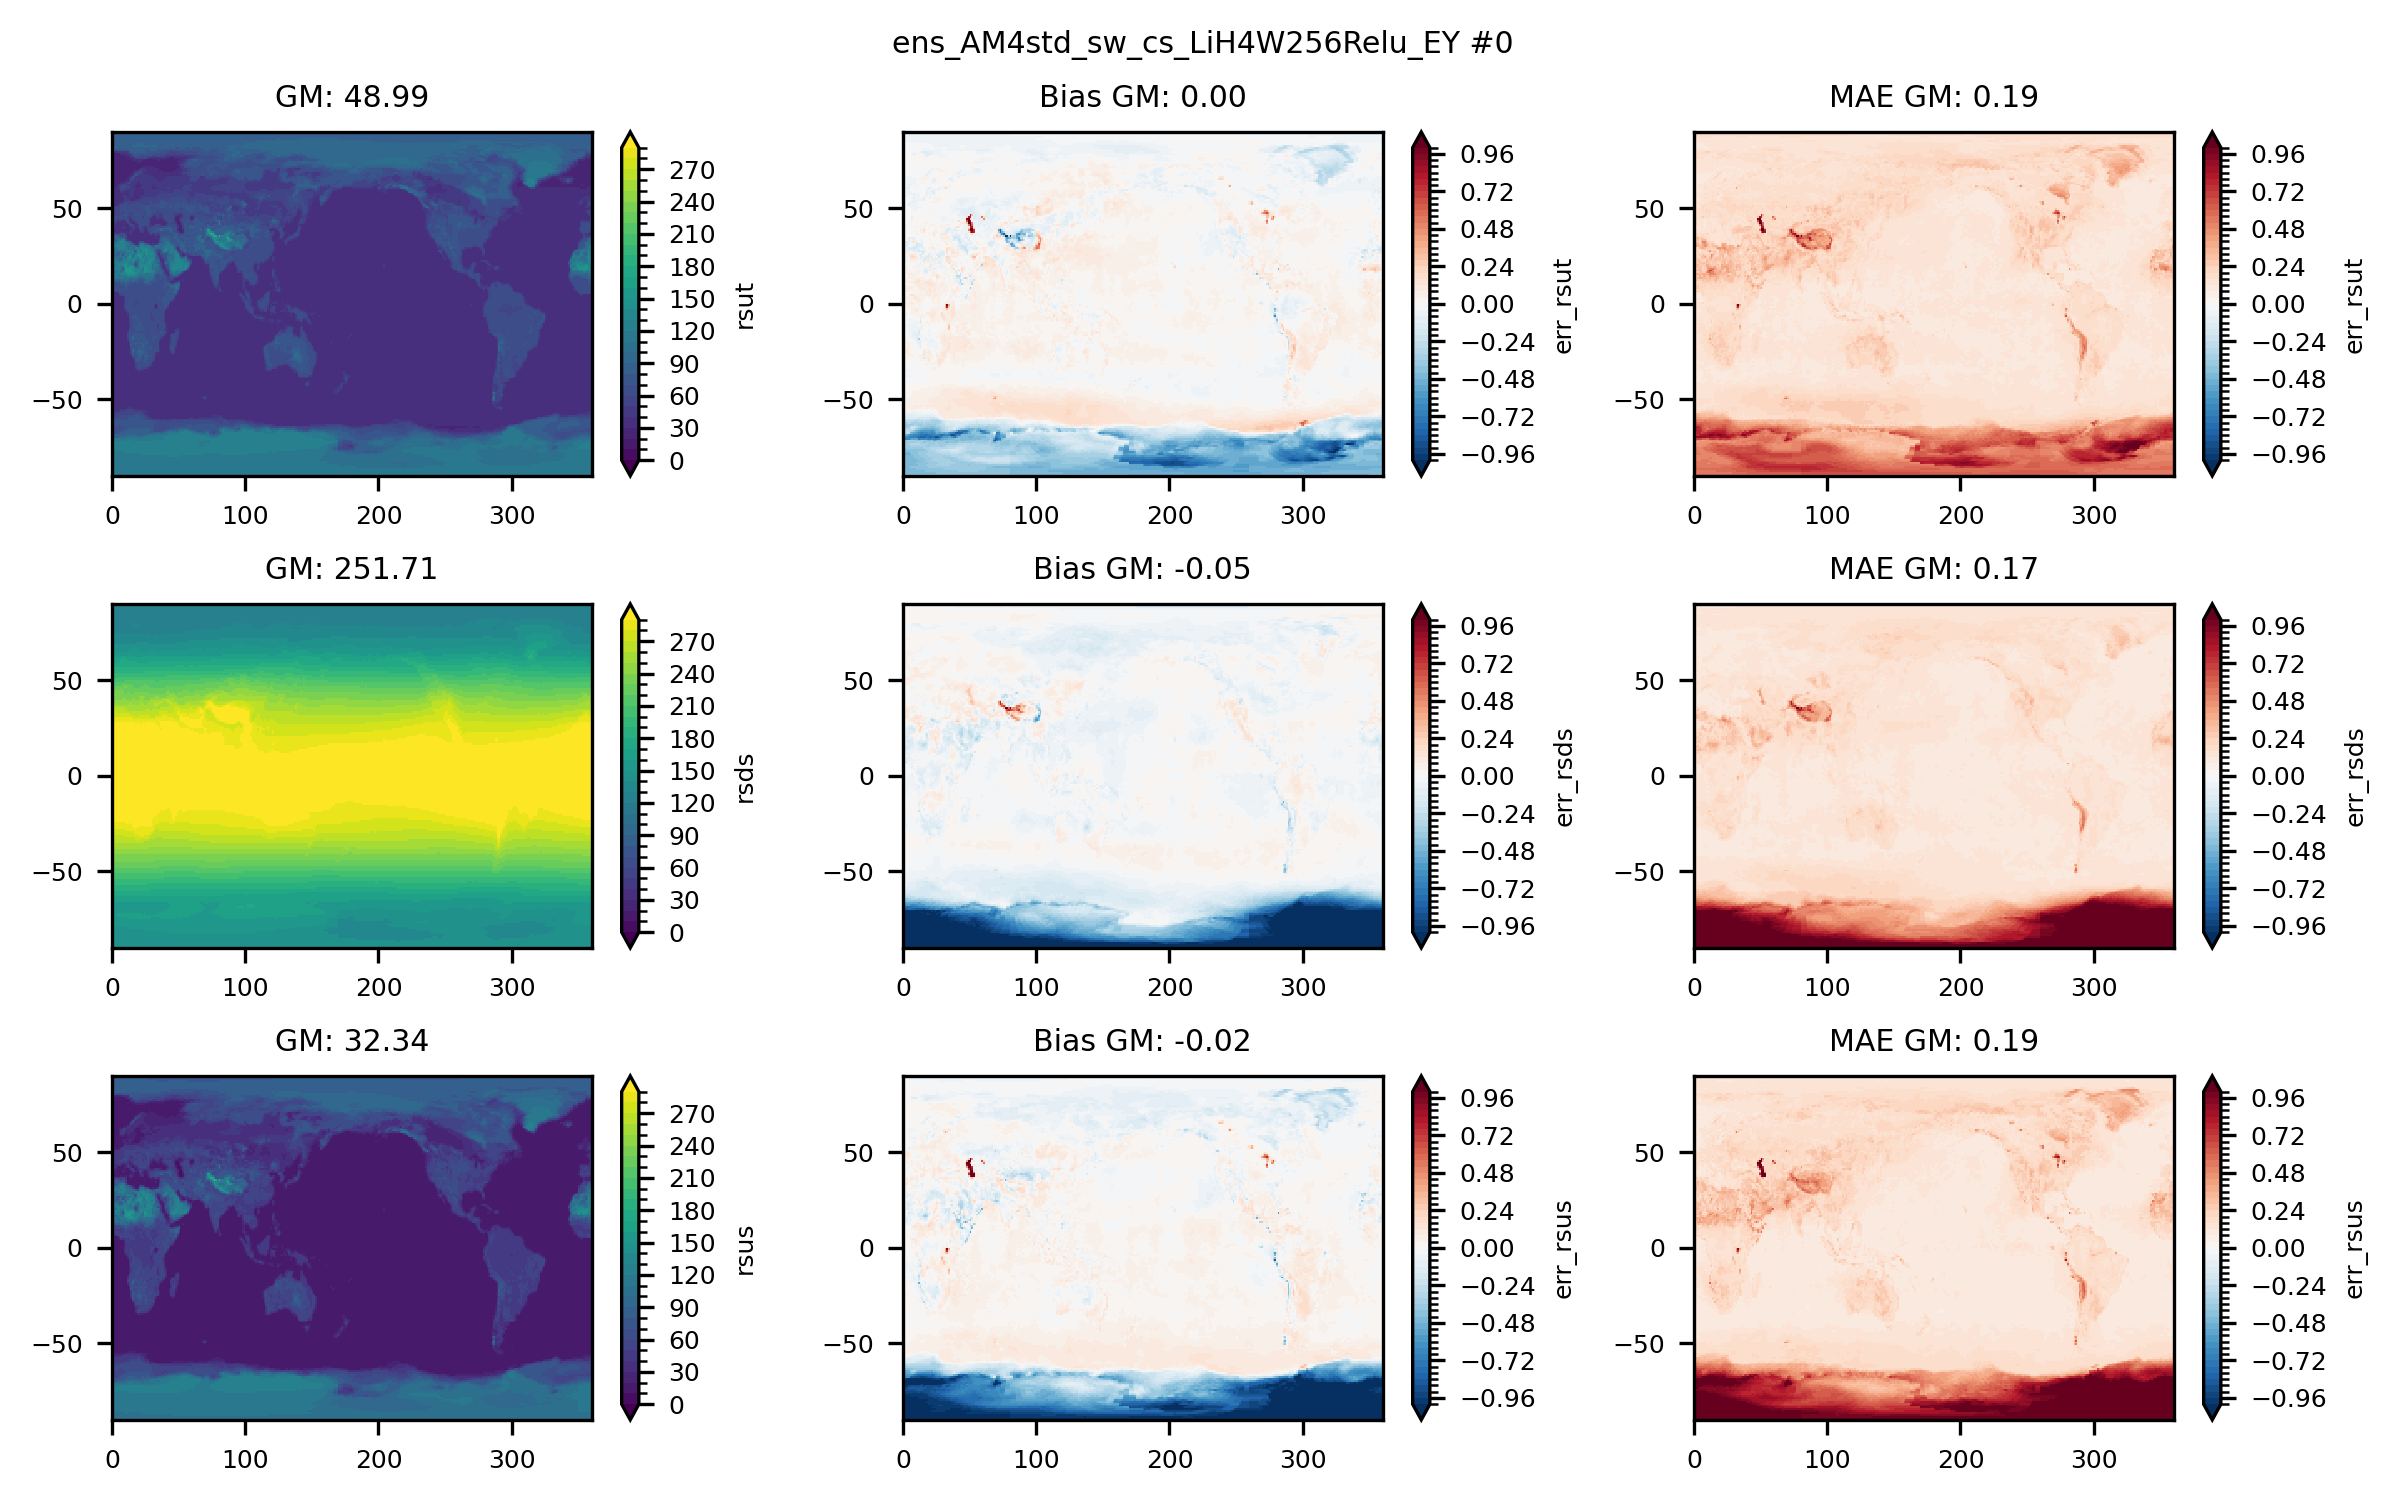

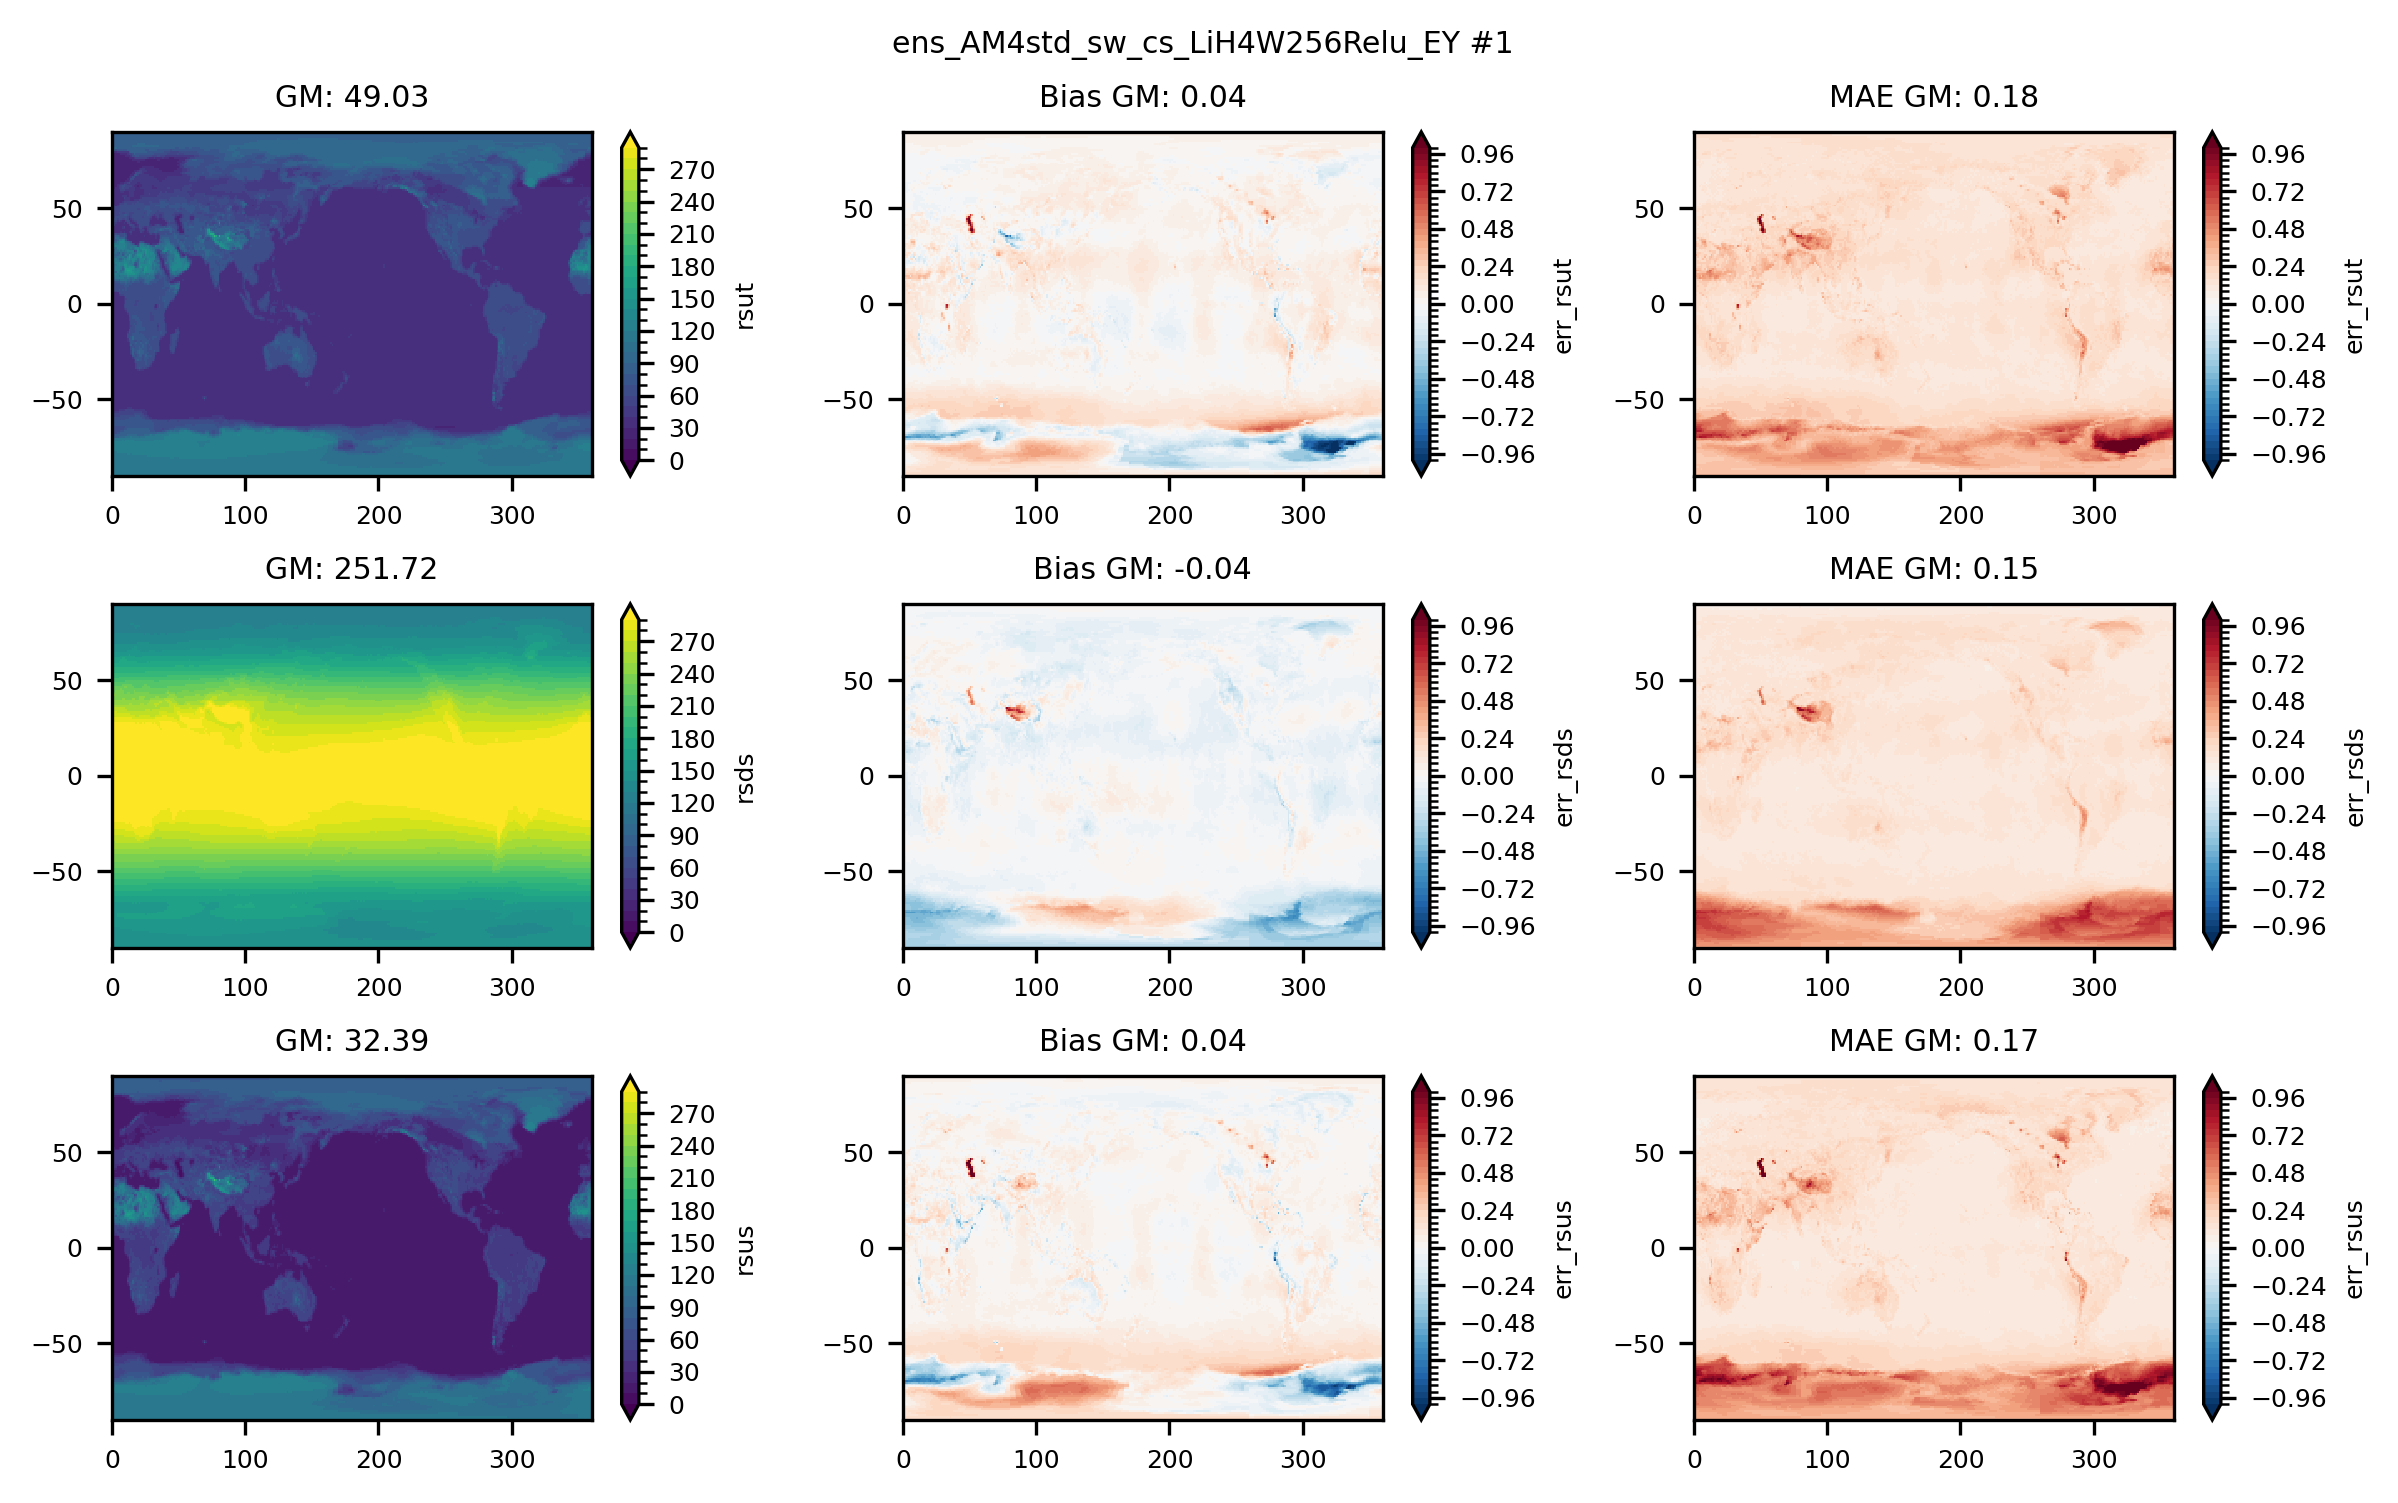

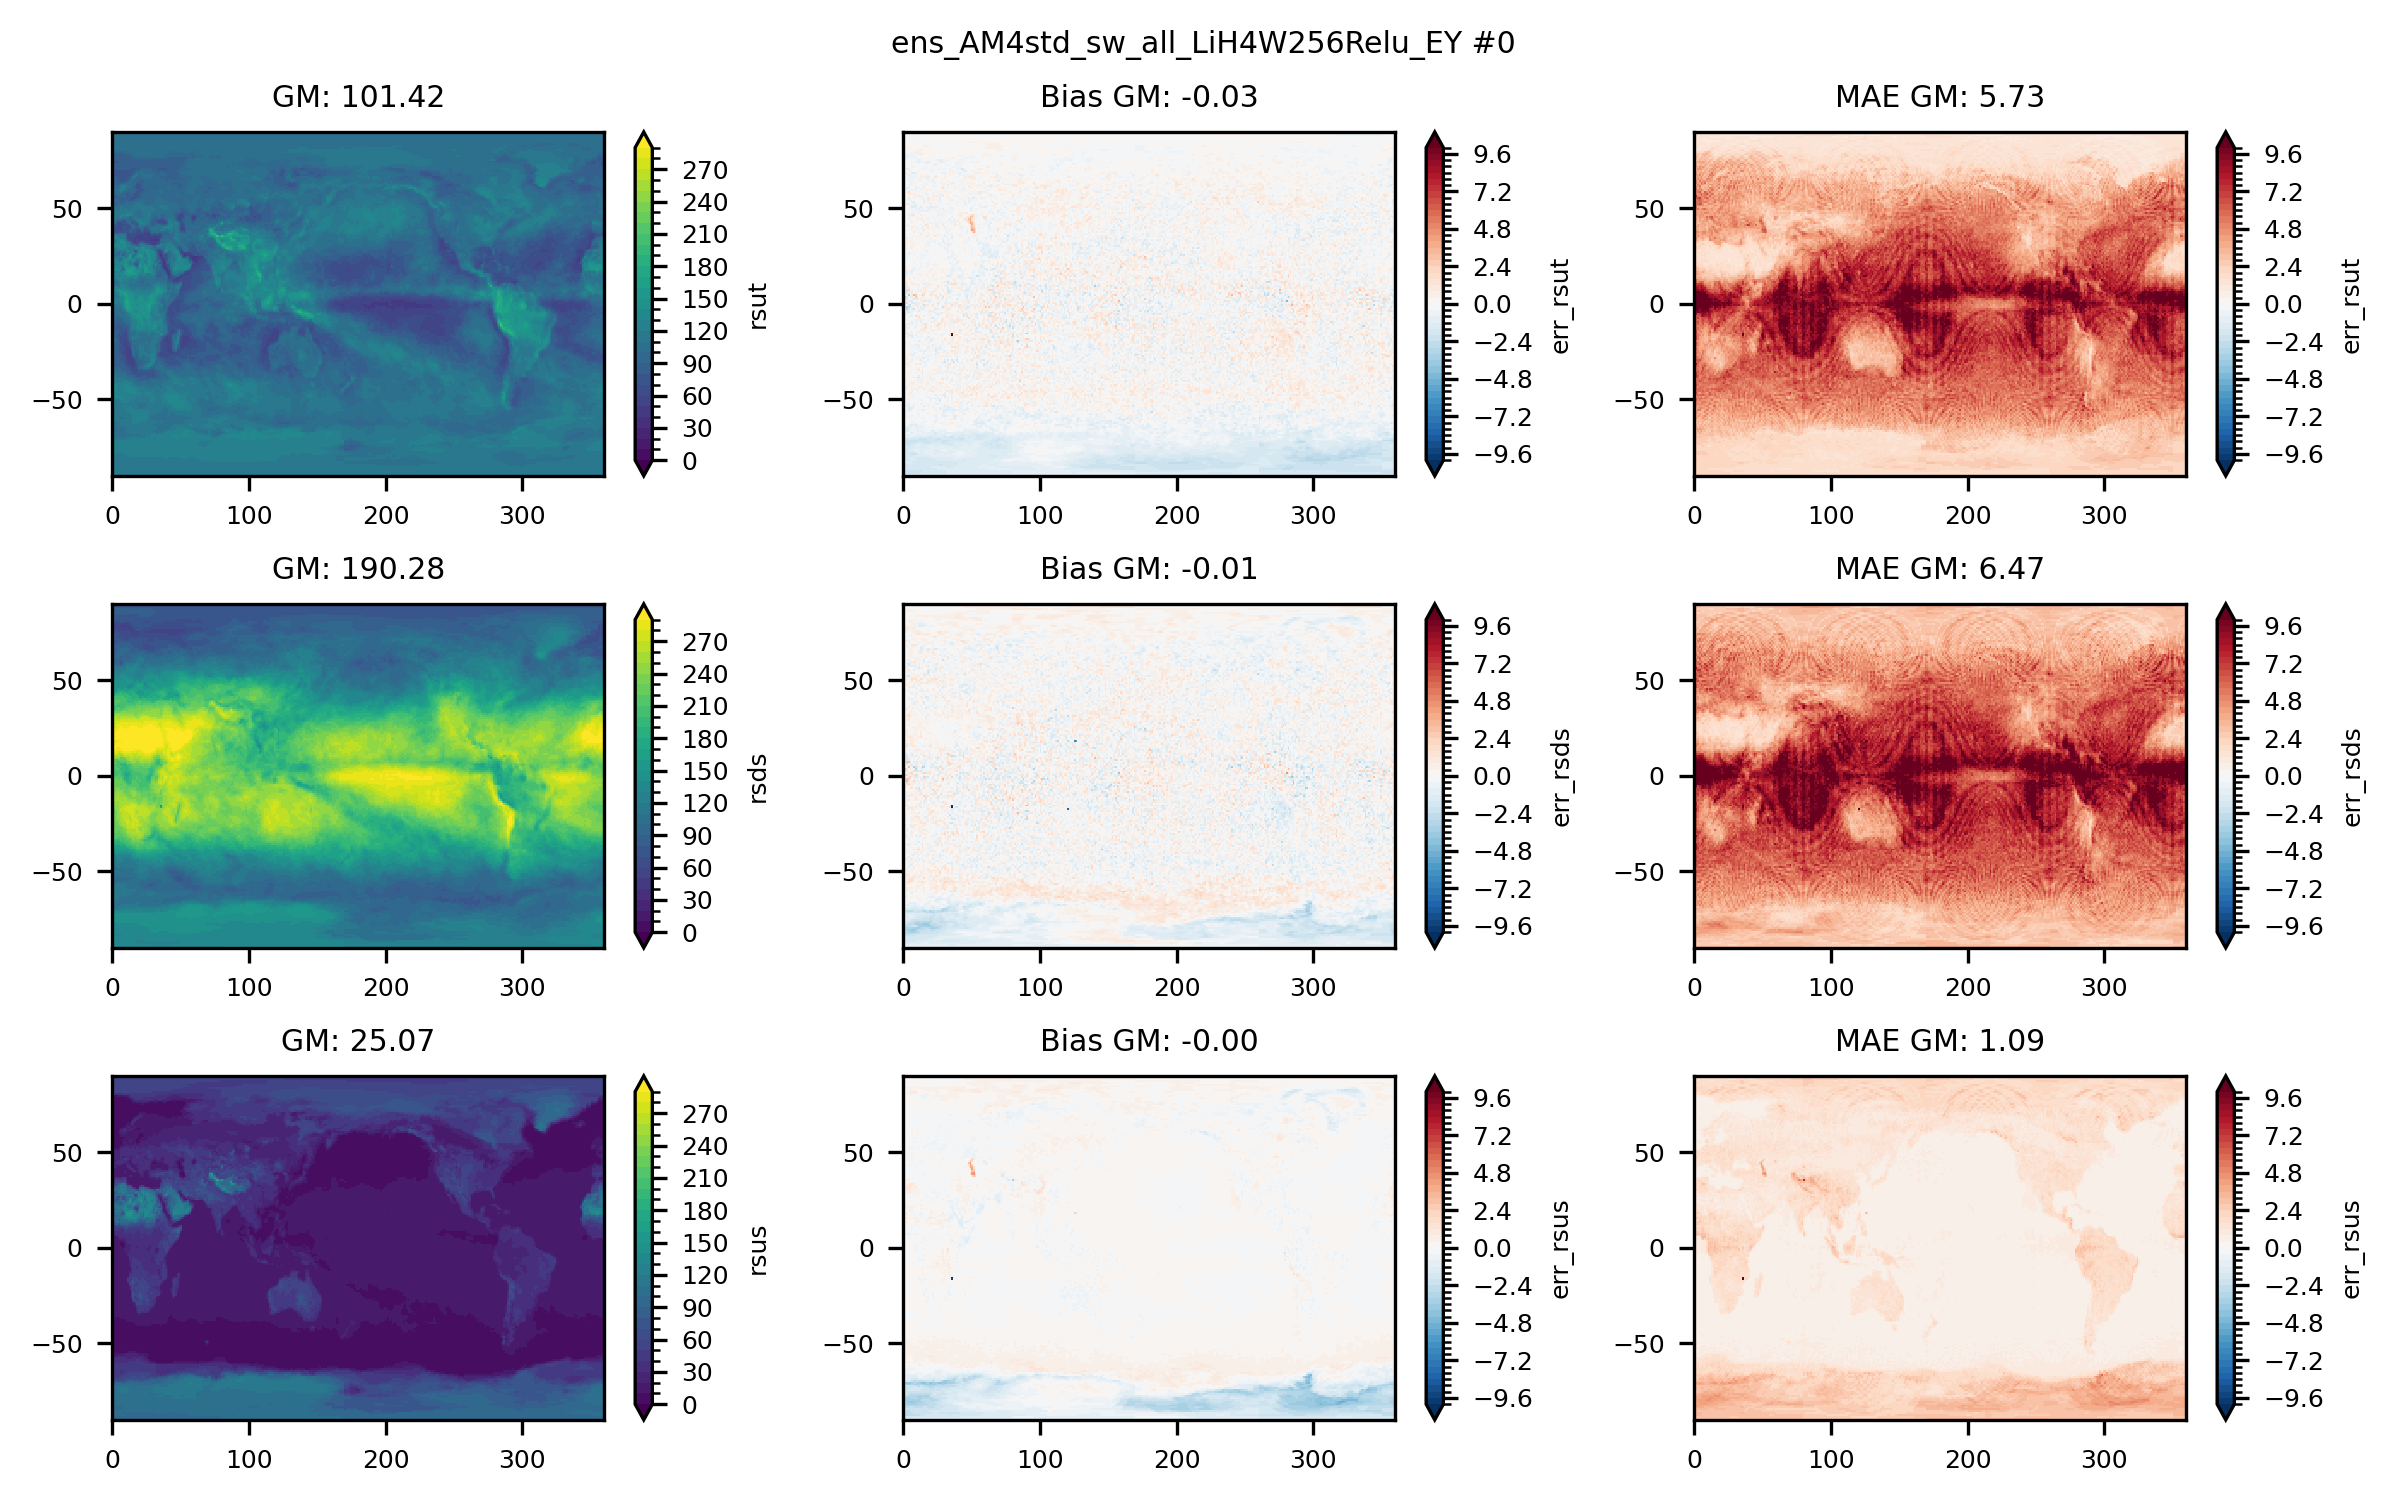

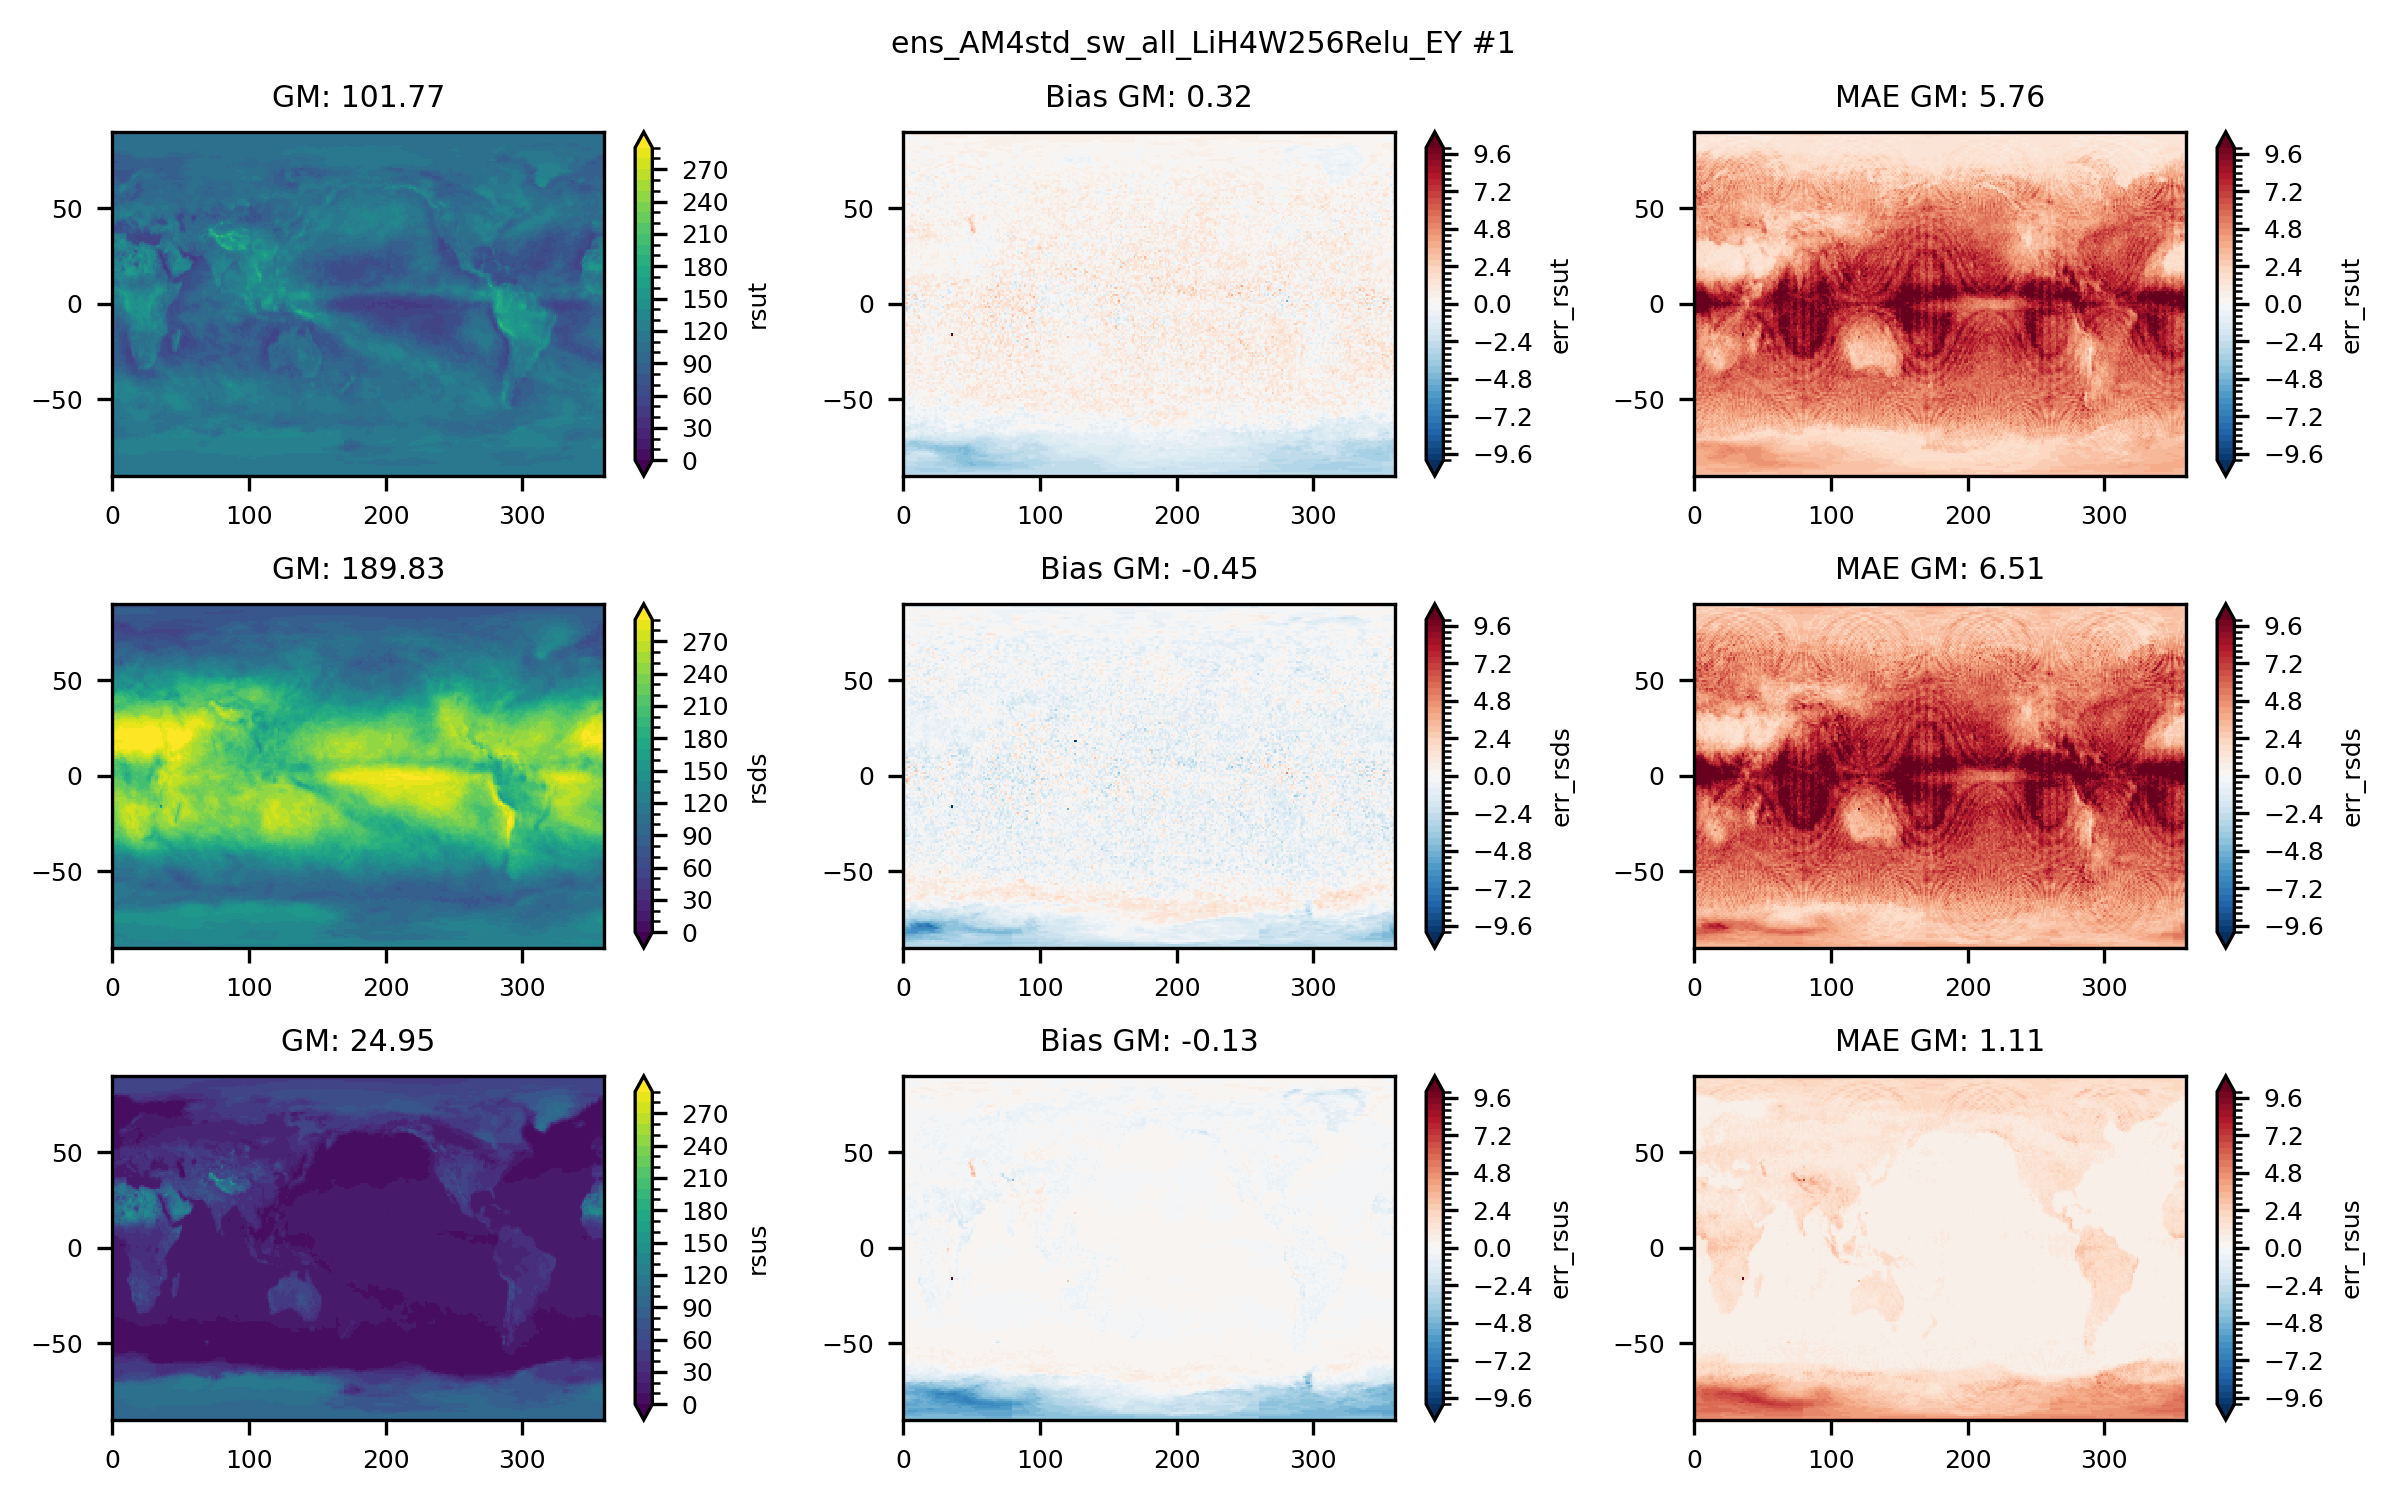

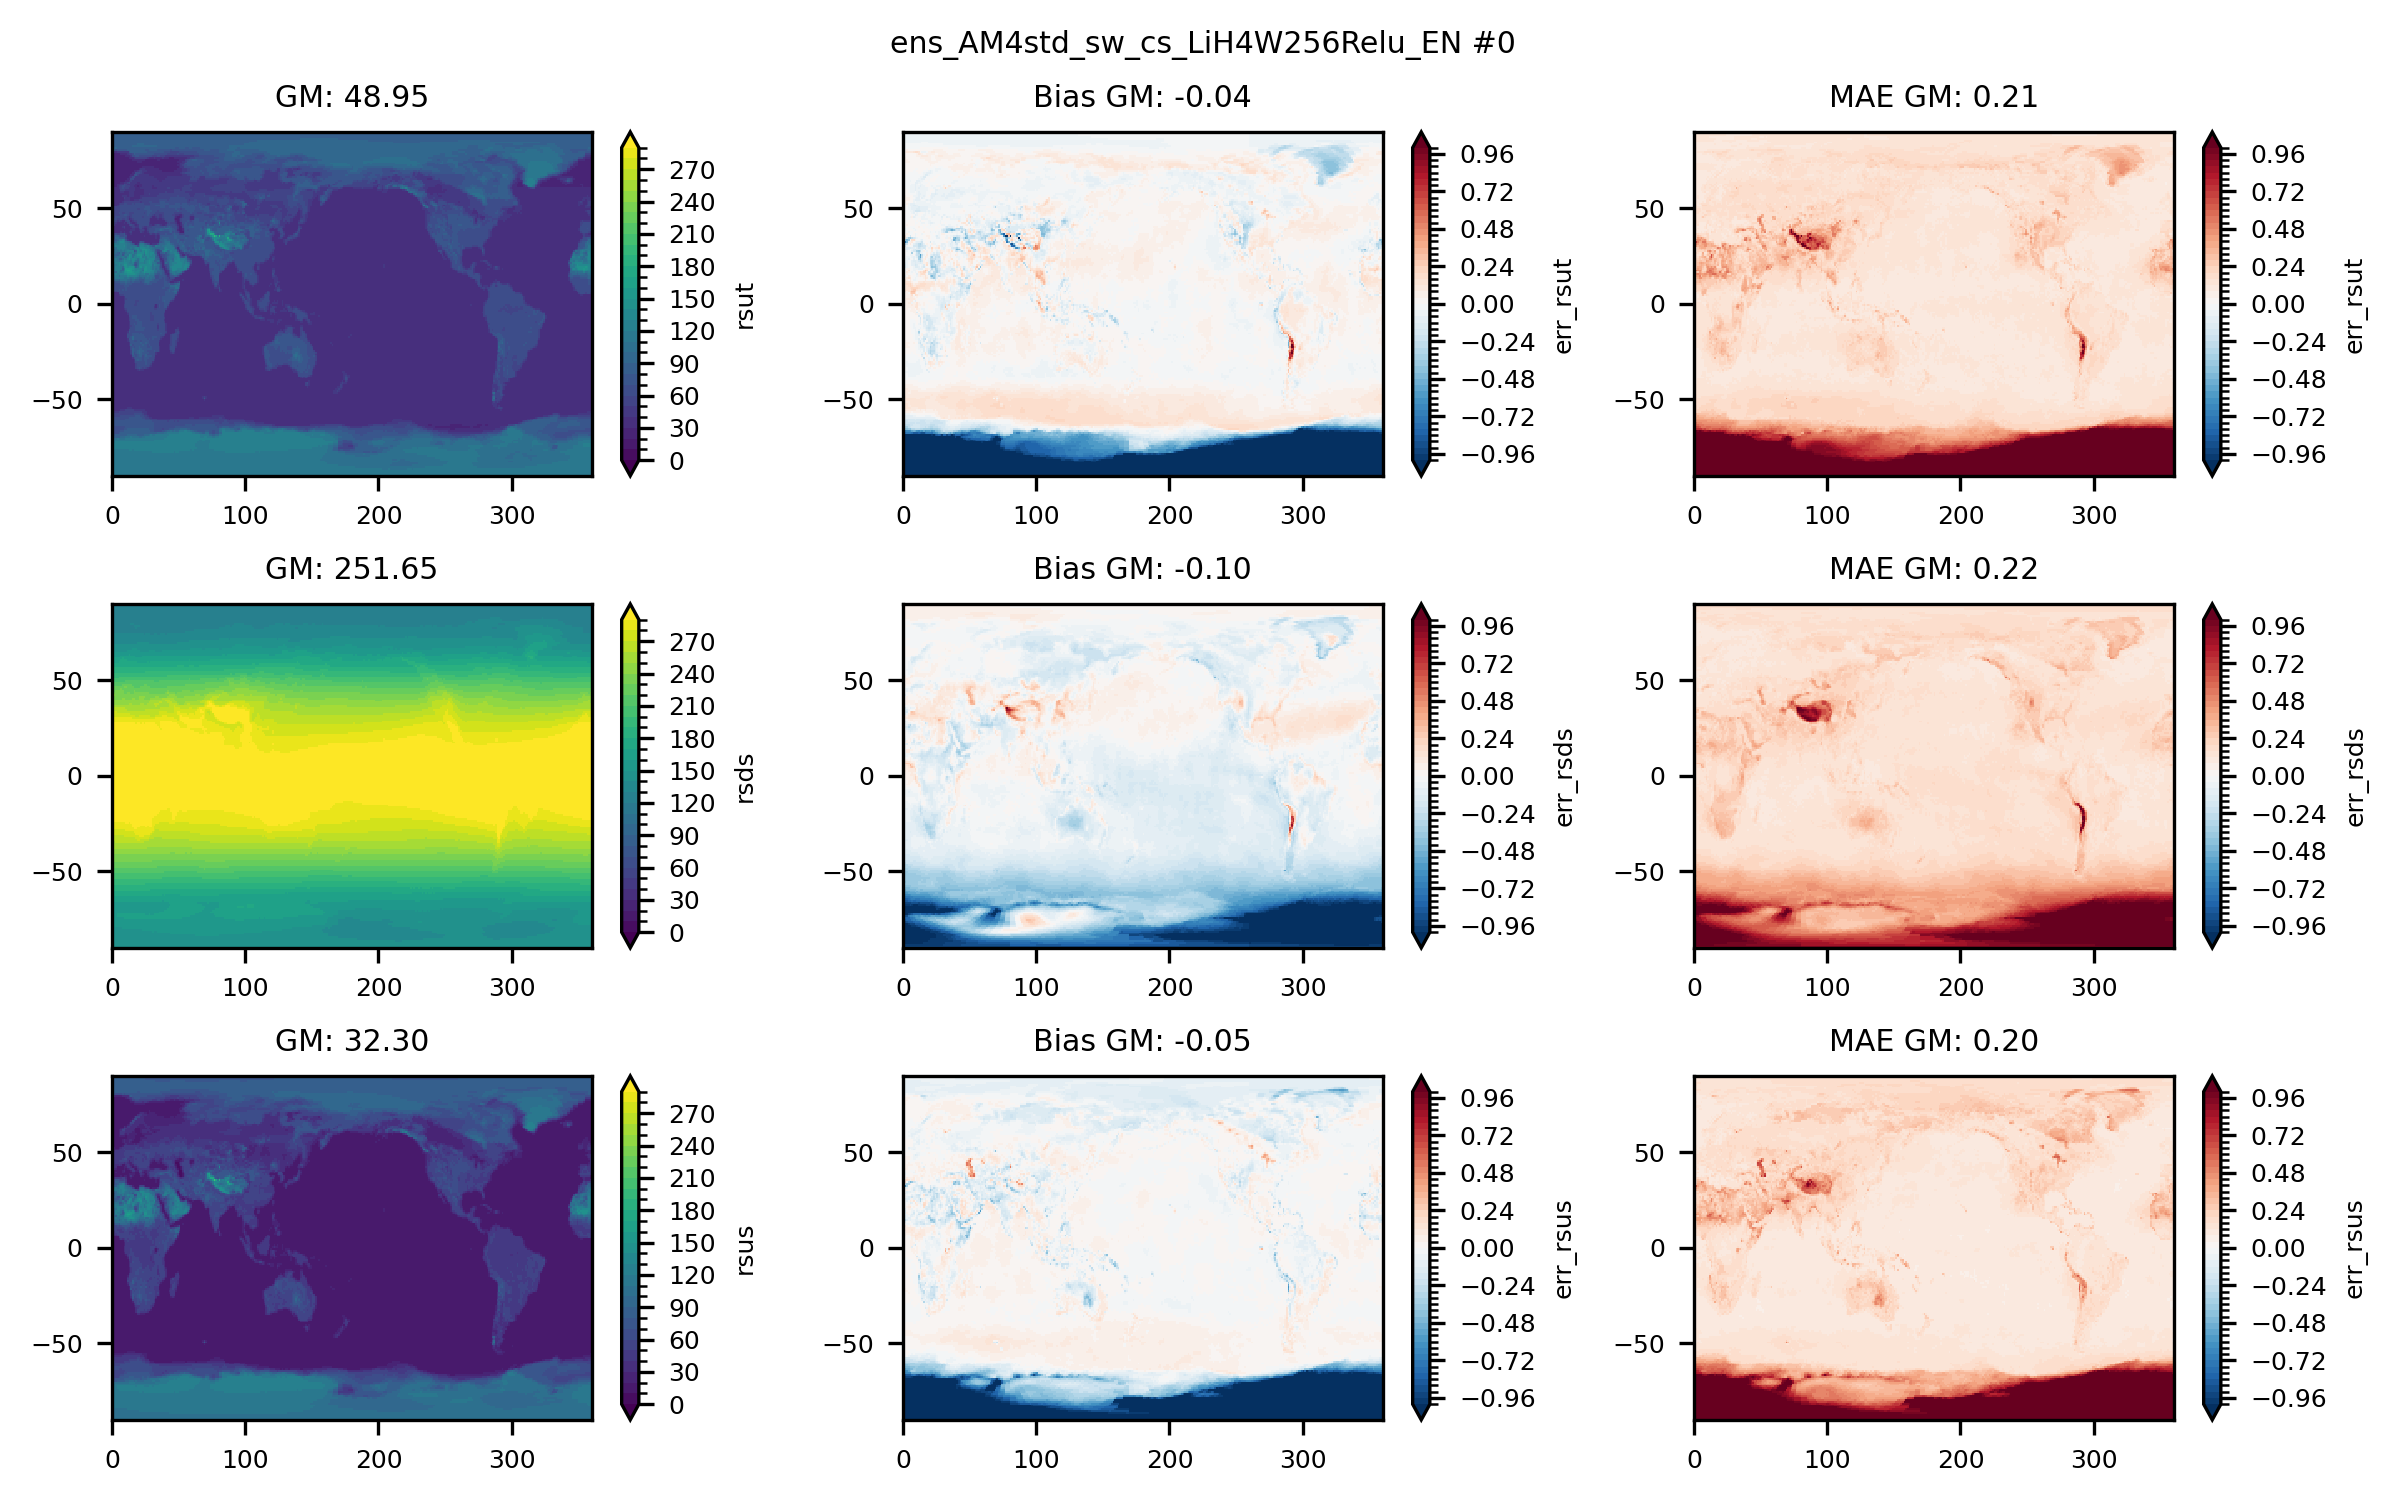

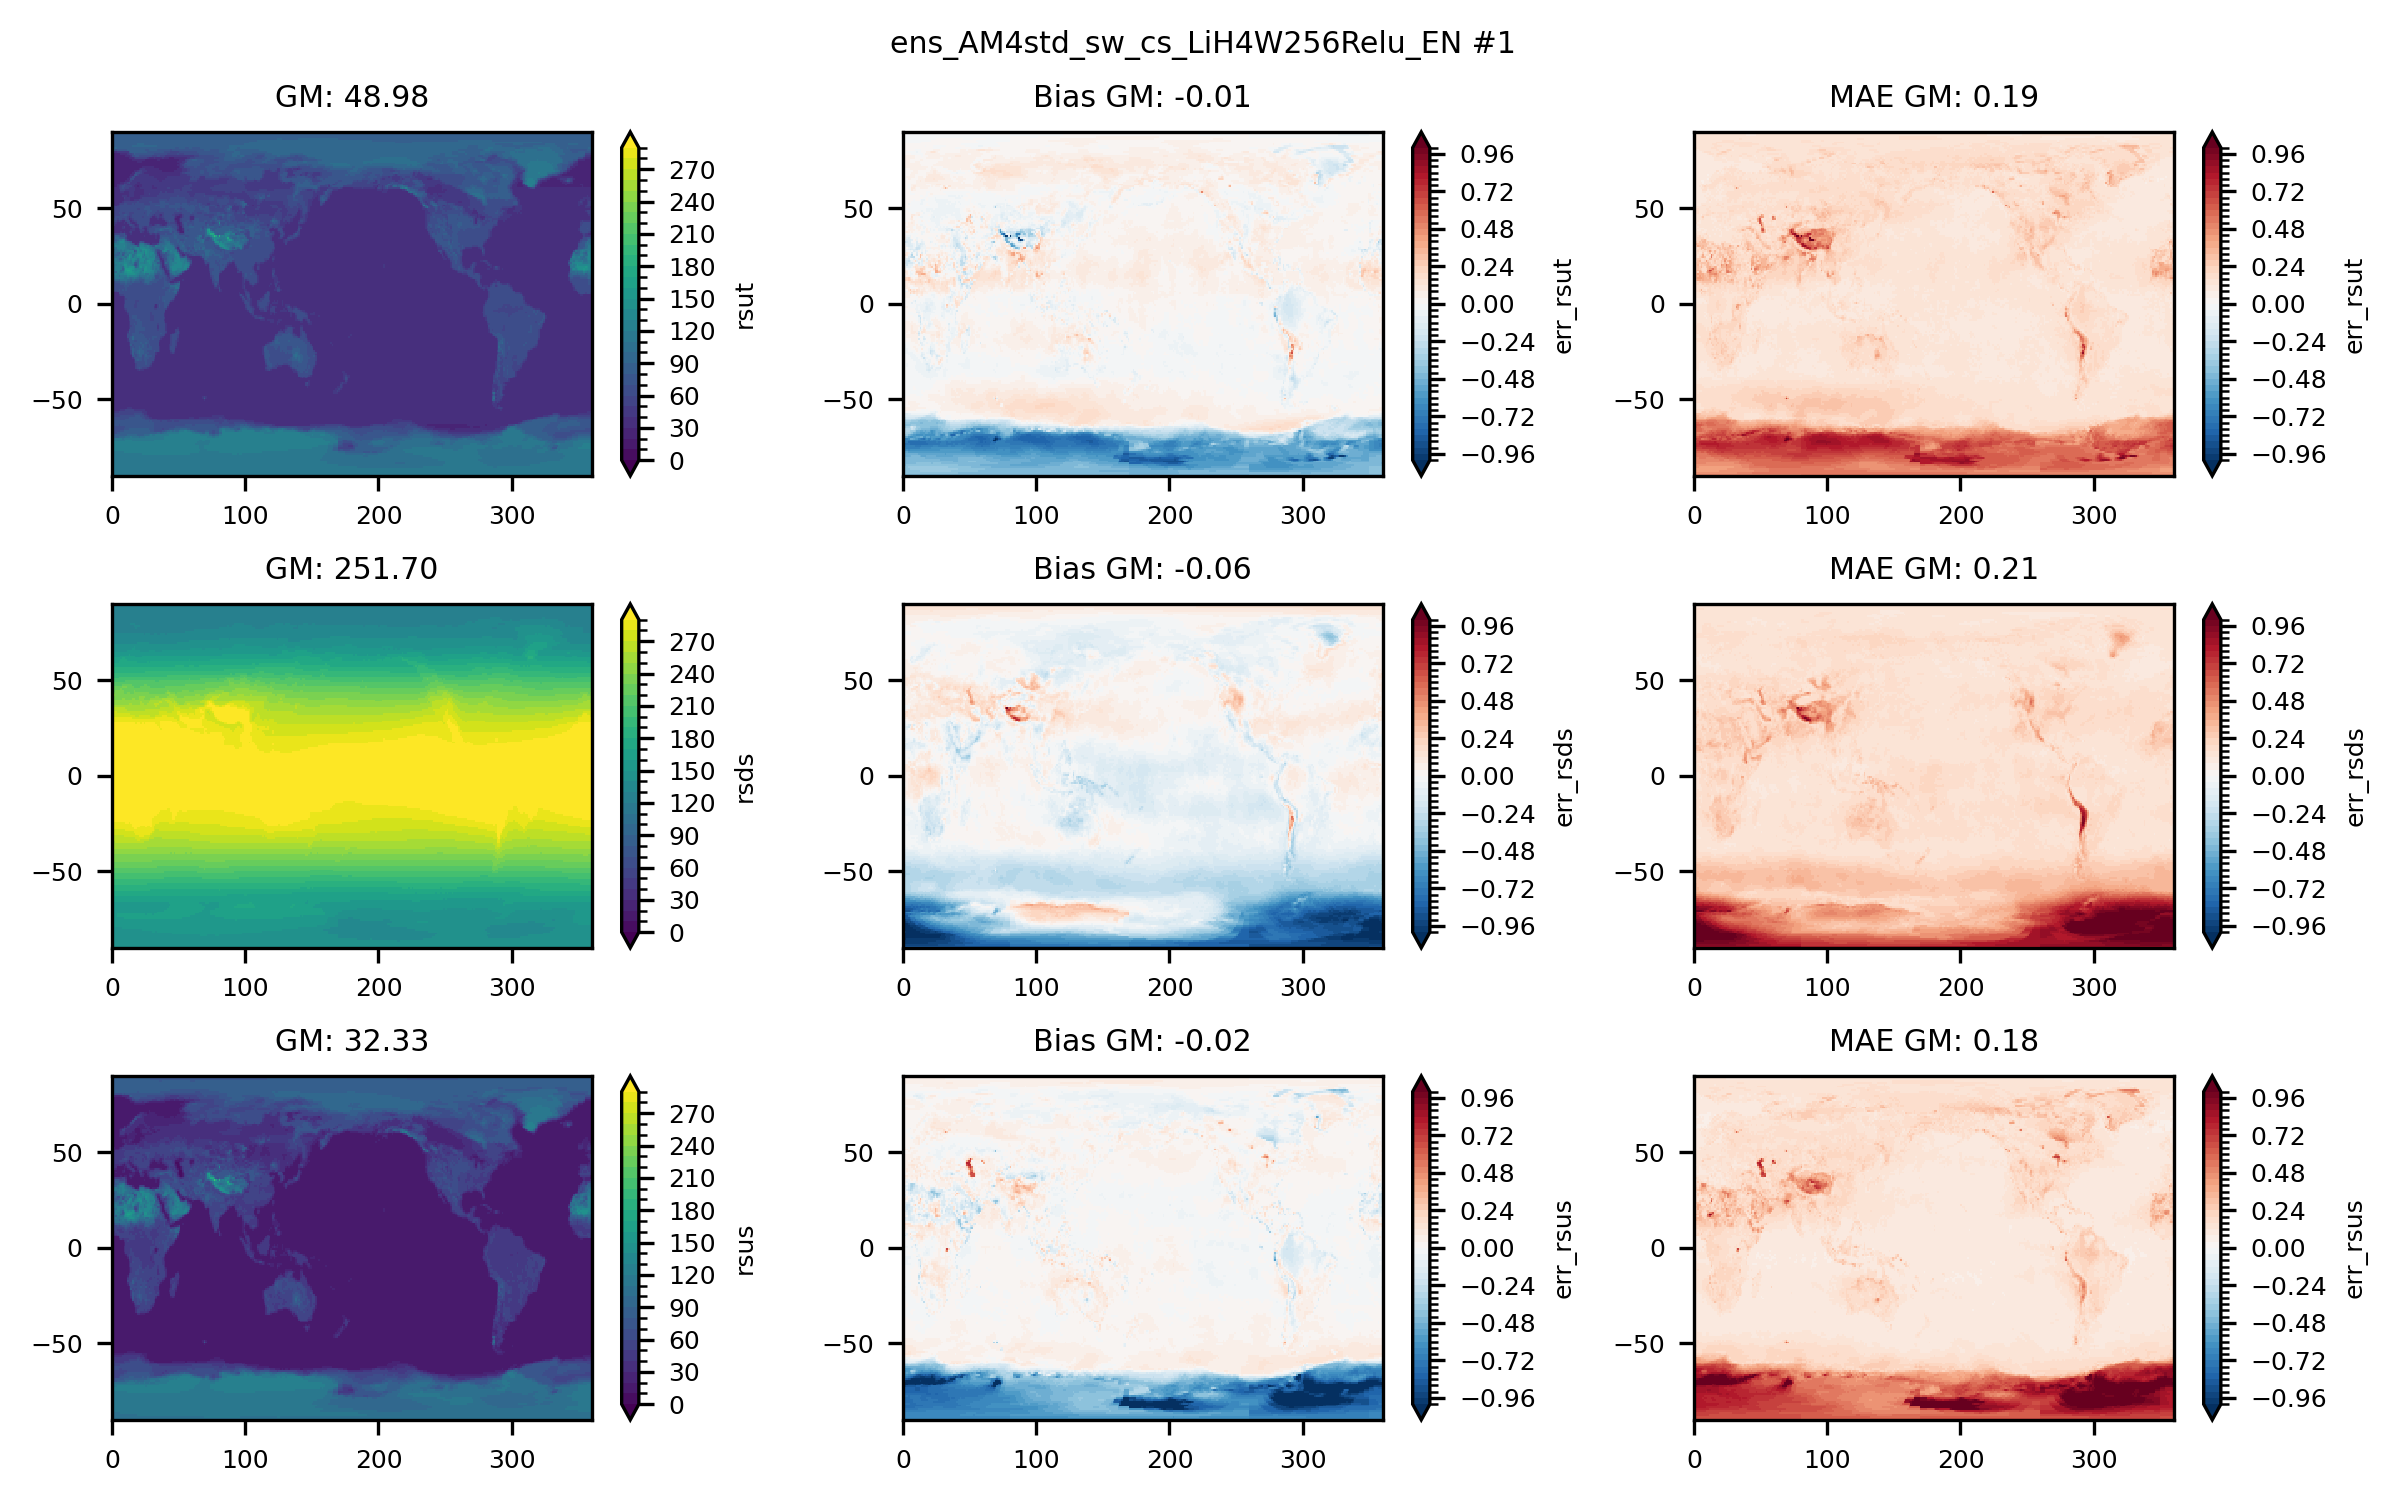

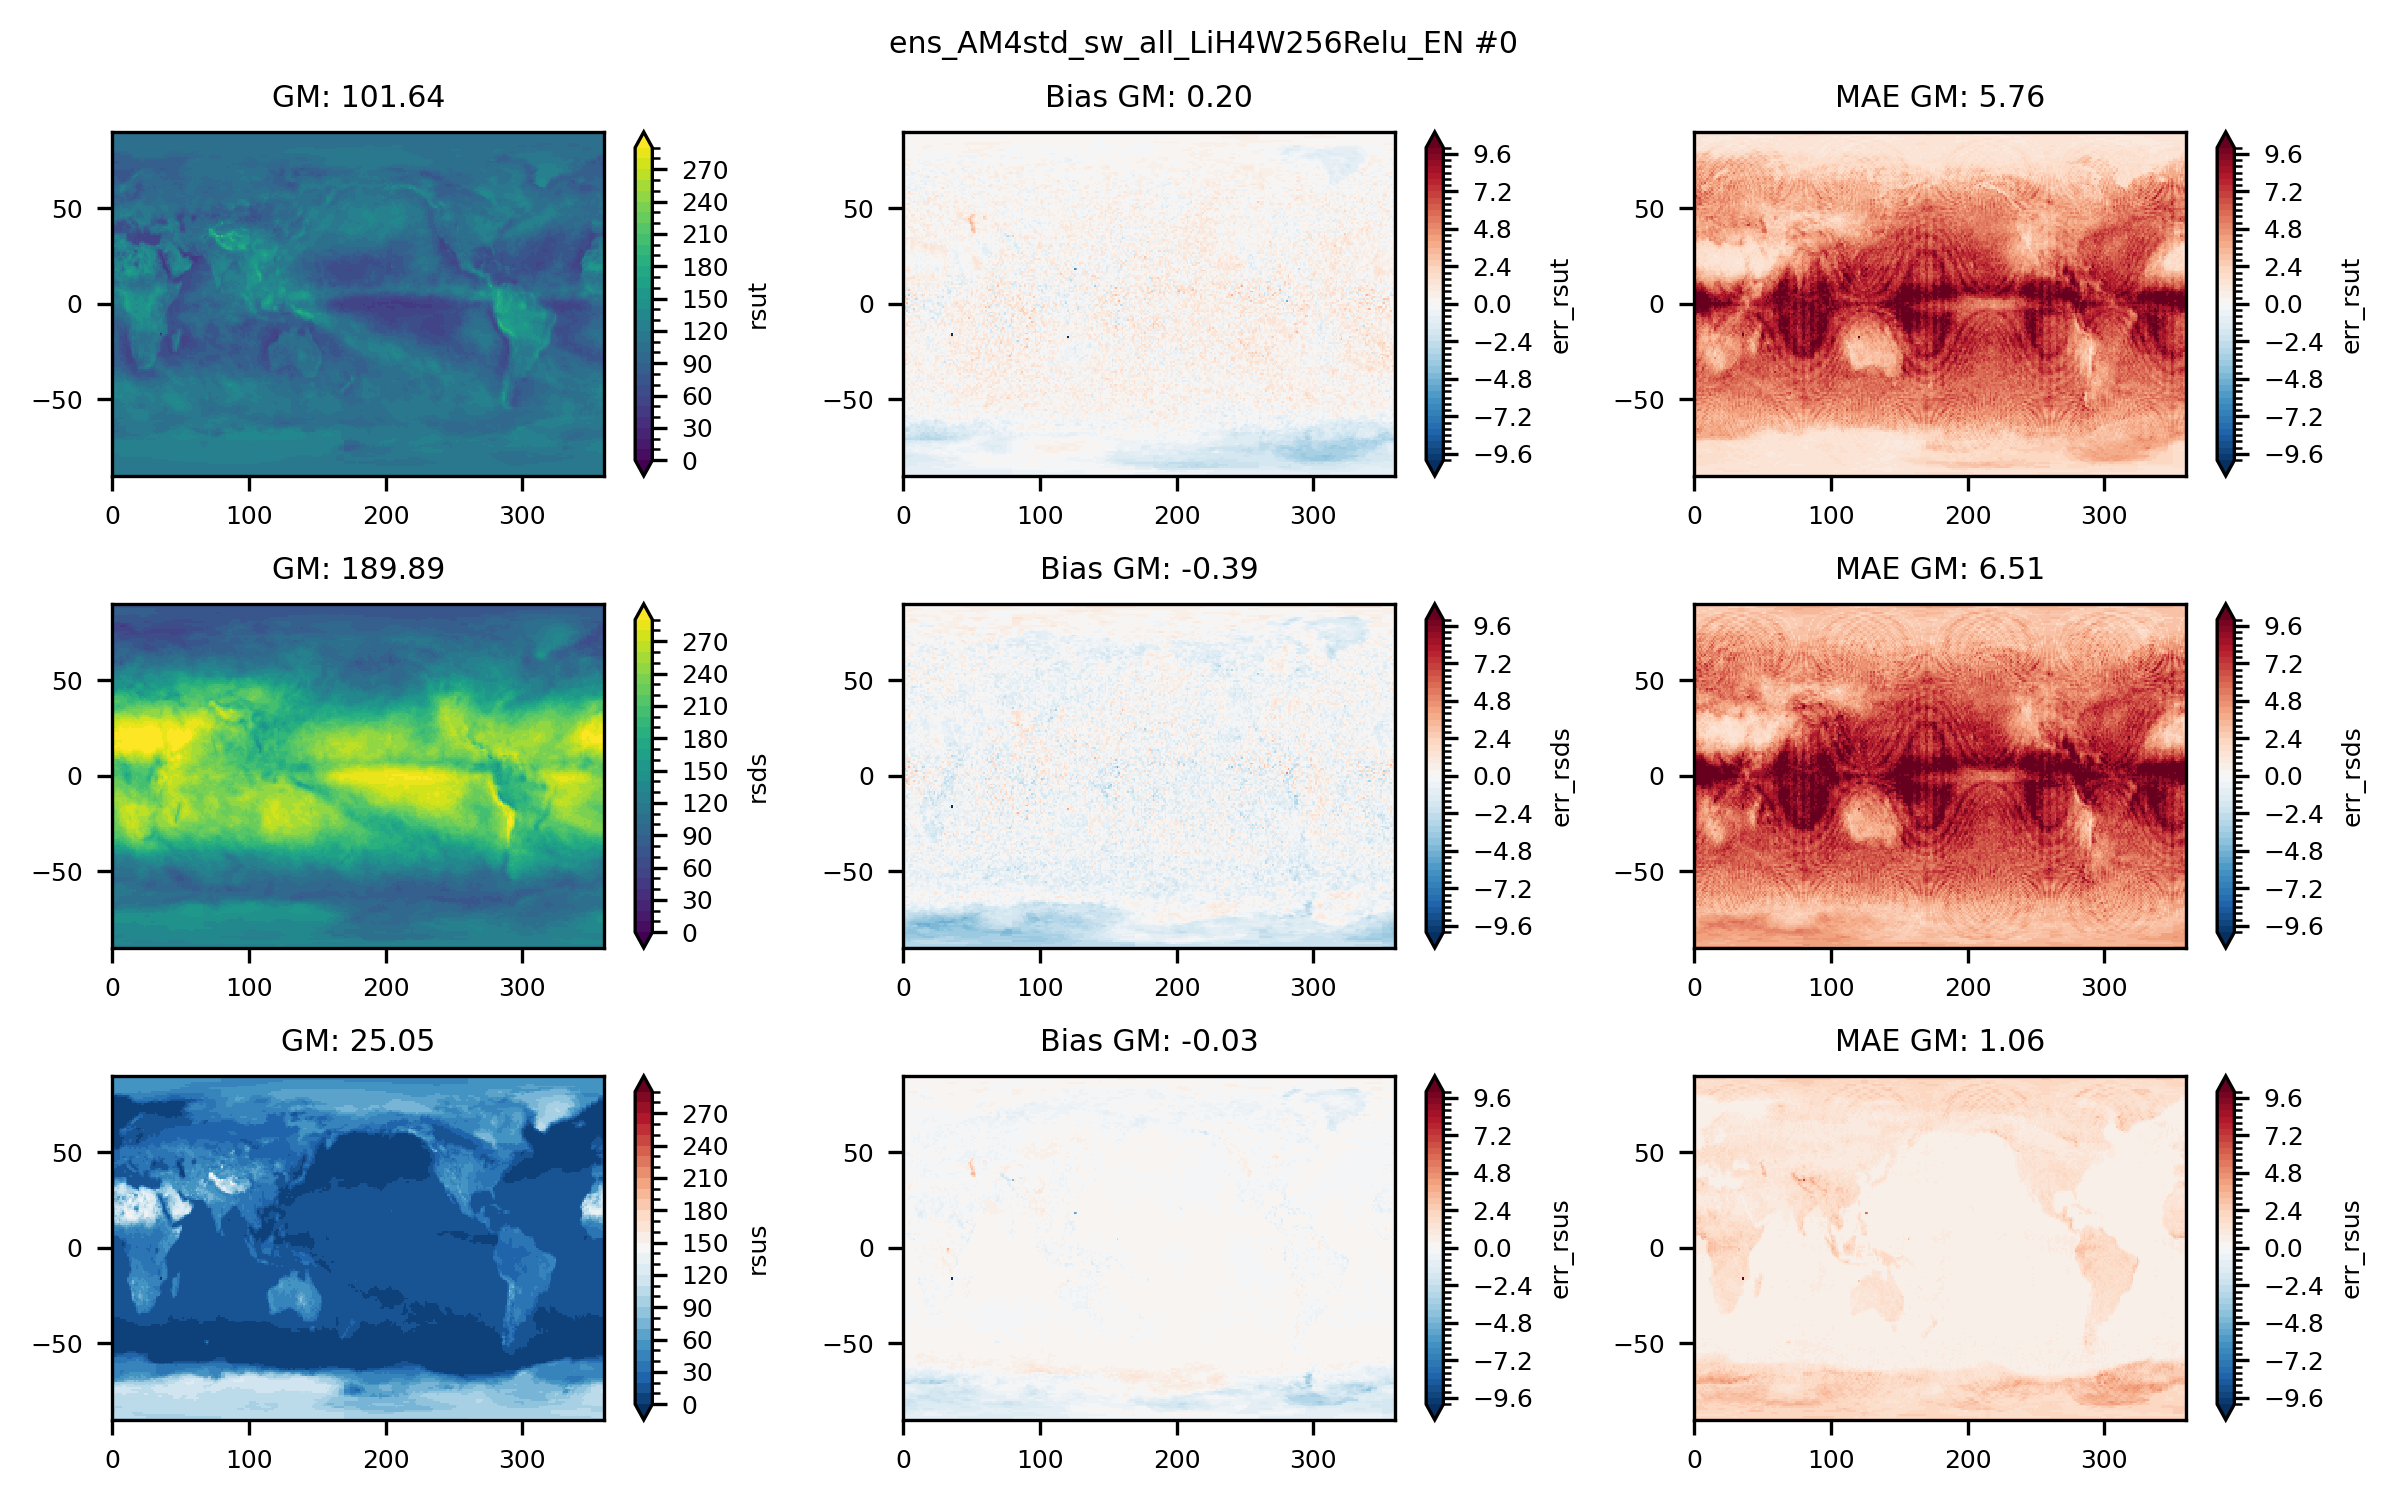

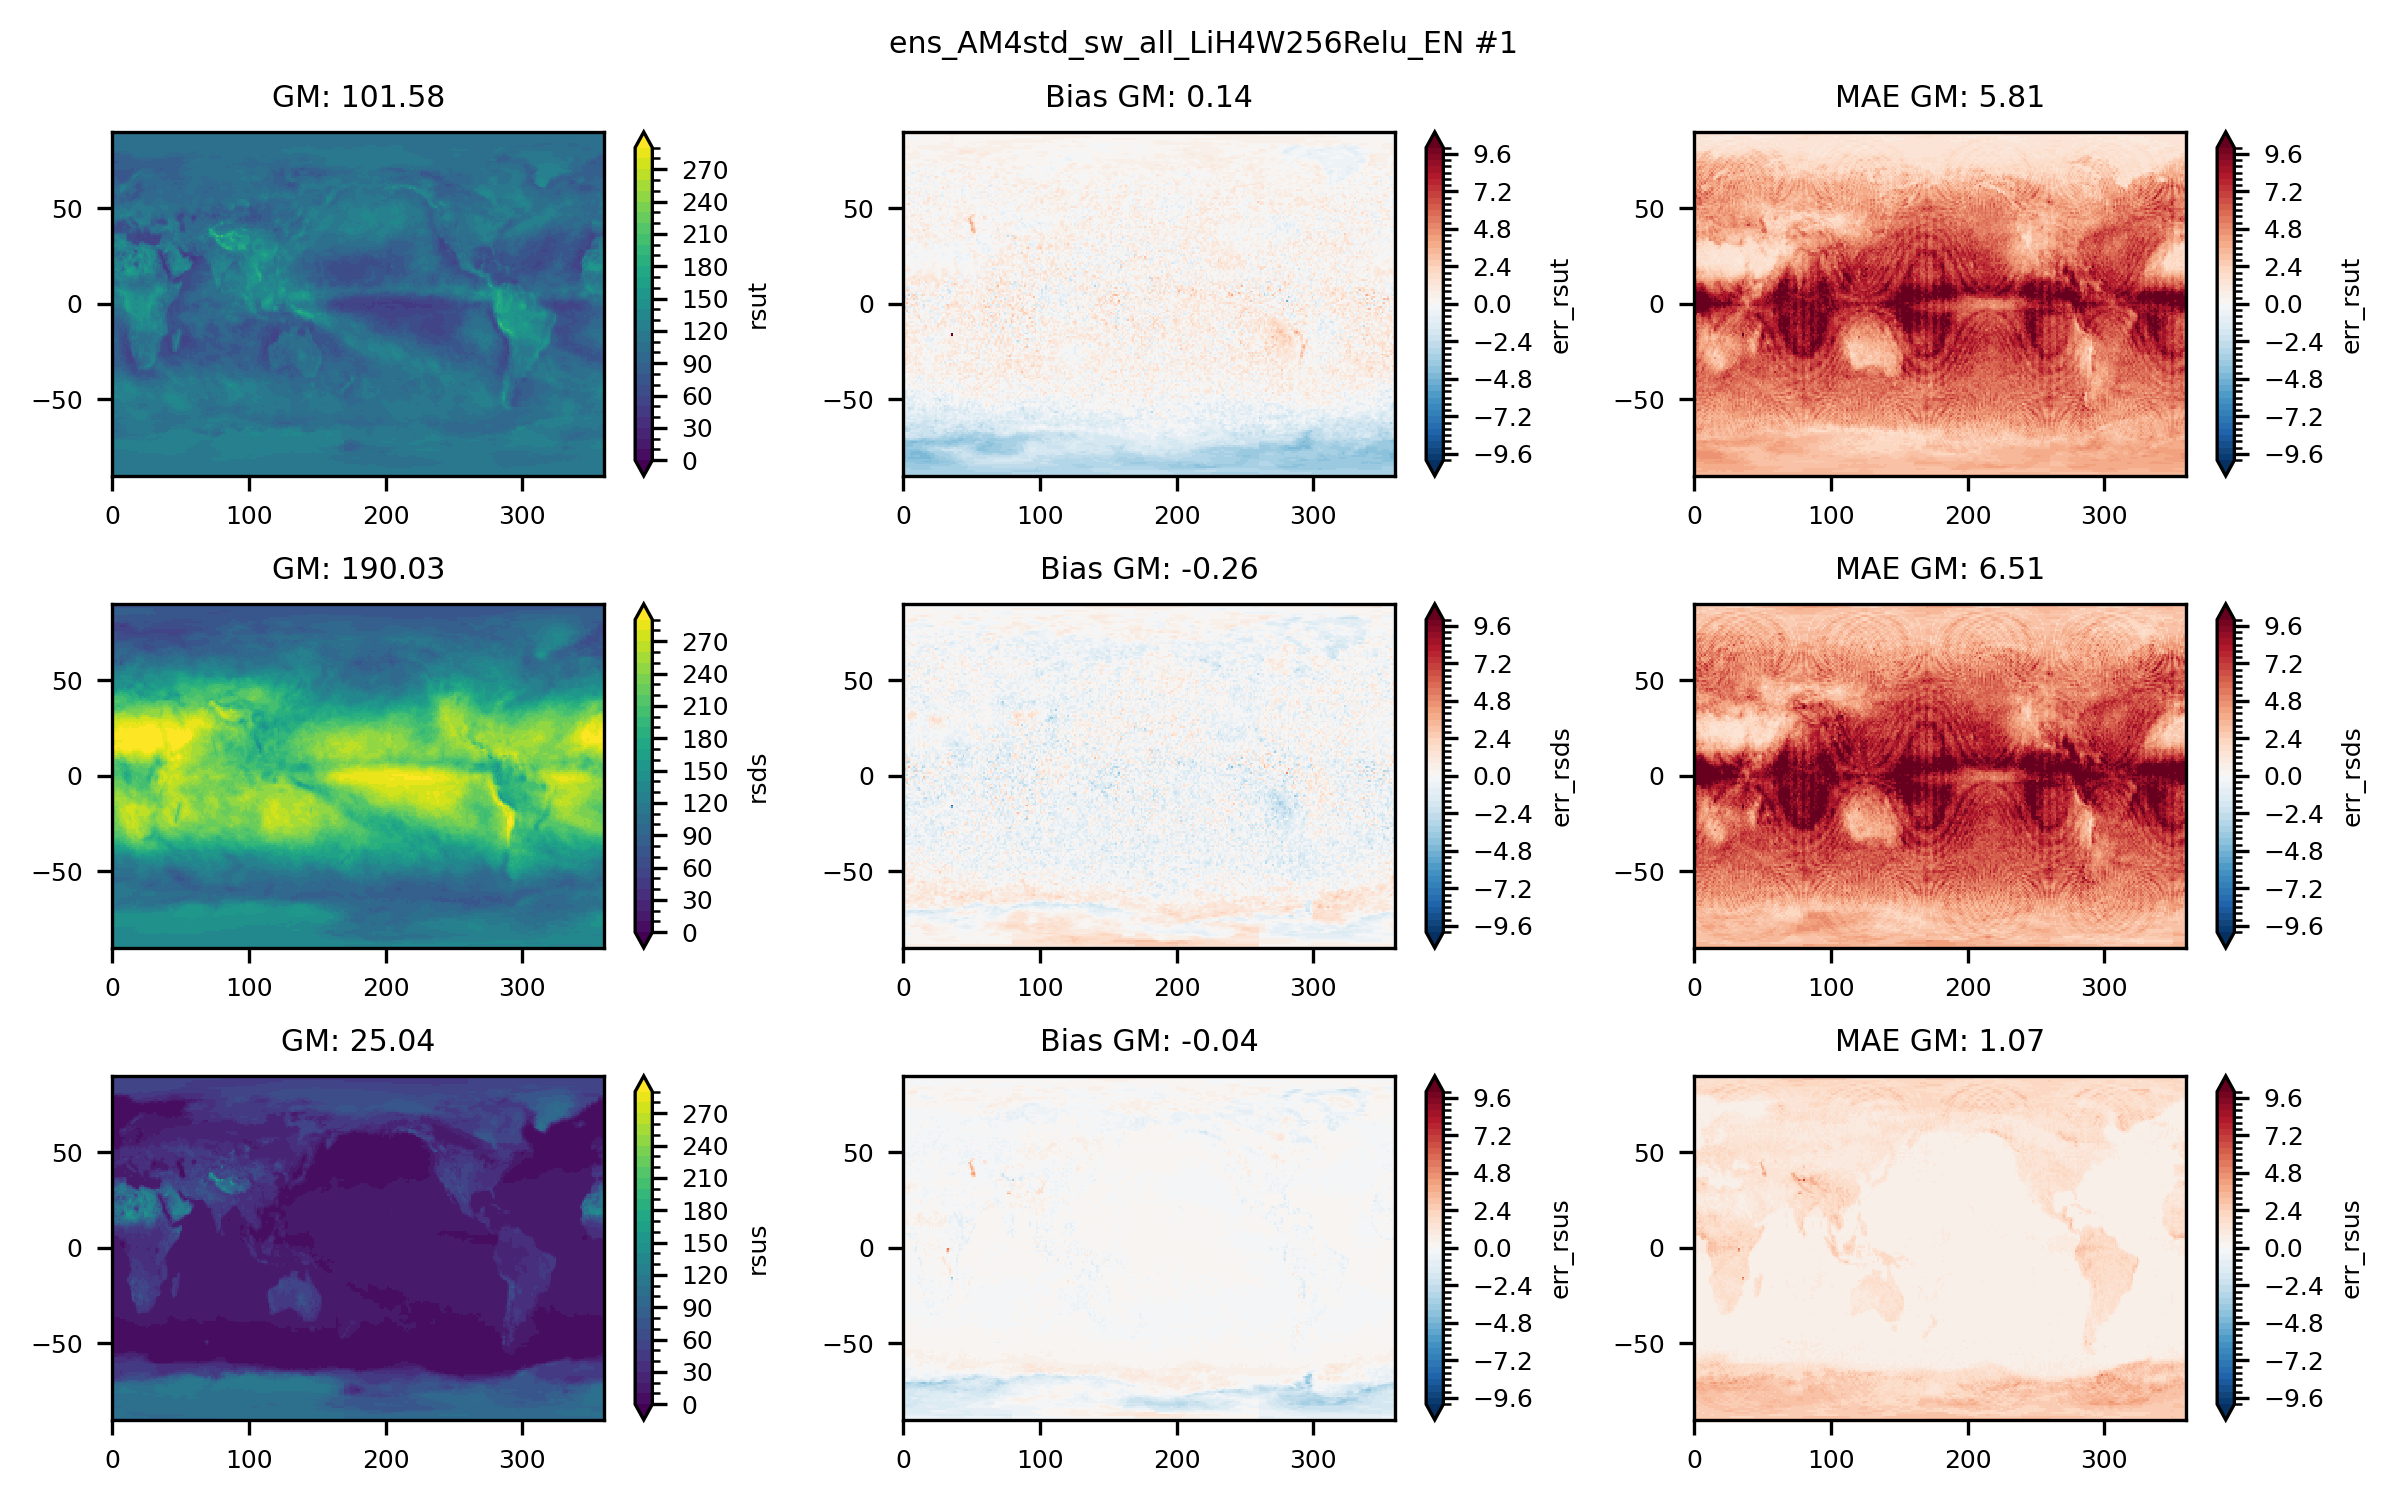

In [14]:
for mo in Exp_name:
    for ei in range(ensemble_size): 
        # time_sel = ds.time.dt.month.isin(month_sel)&ds.time.dt.day.isin(day_sel)
        # ds_plot = ds_regrid[mo][ei].isel(time=time_sel)
        ds_plot = ds_regrid[mo][ei]
        fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(8,5),dpi=300)
        axs = axs.flatten()
        var1 = ['rsut','rsds','rsus']
        level = np.arange(0,300,10)
        for i in range(len(var1)):
            ax=axs[3*i]
            da = ds_plot[var1[i]].mean('time')
            da.plot(ax=ax, levels=level, extend='both') 
            ax.set_title(f'GM: {global_mean_xarray(da).values:4.2f}')
        # level = np.array([-16, -8, -4,-2,-1,-0.5,-0.2,0,0.2,0.5,1,2,4,8,16])
        level = np.arange(-5,5.1,0.2)/5
        if sky_cond[mo] == 'all':  level = level*10
        for i in range(len(var1)):
            ax=axs[3*i+1]
            da = ds_plot['err_'+var1[i]].mean('time')
            da.plot(ax=ax, levels=level, extend='both')   
            ax.set_title(f'Bias GM: {global_mean_xarray(da).values:4.2f}')
                         # +f'\n lat>-60: {global_mean_xarray(da.sel(lat=slice(-60,90))).values:4.2f}')
        for i in range(len(var1)):
            ax=axs[3*i+2]
            da = abs(ds_plot['err_'+var1[i]]).mean('time')
            da.plot(ax=ax, levels=level, extend='both')   
            ax.set_title(f'MAE GM: {global_mean_xarray(da).values:4.2f}')
                         # +f'\n lat>-60: {global_mean_xarray(da.sel(lat=slice(-60,90))).values:4.2f}') 
        for ax in axs:
            ax.set(xlabel=None,ylabel=None)
        plt.suptitle(f'{mo} #{ei}')
        fig.tight_layout()

In [15]:
print('GM: Bias, MAE, RMSE')
for mo in Exp_name:
    for ei in range(ensemble_size): 
        print(f'{mo} #{ei}')
        ds_plot = ds_regrid[mo][ei]
        for i in range(len(var1)): 
            da = global_mean_xarray(ds_plot['err_'+var1[i]])
            Bias = da.mean()
            MAE  = abs(da).mean()
            RMSE = ((da**2).mean())**0.5
            print(f'err_{var1[i]}: {Bias.values:4.2f}, {MAE.values:4.2f}, {RMSE.values:4.2f},') 

GM: Bias, MAE, RMSE
ens_AM4std_sw_cs_LiH4W256Relu_EY #0
err_rsut: 0.00, 0.02, 0.02,
err_rsds: -0.05, 0.05, 0.07,
err_rsus: -0.02, 0.03, 0.05,
ens_AM4std_sw_cs_LiH4W256Relu_EY #1
err_rsut: 0.04, 0.04, 0.05,
err_rsds: -0.04, 0.04, 0.05,
err_rsus: 0.04, 0.04, 0.05,
ens_AM4std_sw_all_LiH4W256Relu_EY #0
err_rsut: -0.03, 0.12, 0.15,
err_rsds: -0.01, 0.14, 0.20,
err_rsus: -0.00, 0.09, 0.12,
ens_AM4std_sw_all_LiH4W256Relu_EY #1
err_rsut: 0.32, 0.33, 0.36,
err_rsds: -0.45, 0.45, 0.50,
err_rsus: -0.13, 0.14, 0.19,
ens_AM4std_sw_cs_LiH4W256Relu_EN #0
err_rsut: -0.04, 0.05, 0.08,
err_rsds: -0.10, 0.10, 0.13,
err_rsus: -0.05, 0.06, 0.10,
ens_AM4std_sw_cs_LiH4W256Relu_EN #1
err_rsut: -0.01, 0.03, 0.04,
err_rsds: -0.06, 0.07, 0.09,
err_rsus: -0.02, 0.03, 0.06,
ens_AM4std_sw_all_LiH4W256Relu_EN #0
err_rsut: 0.20, 0.21, 0.25,
err_rsds: -0.39, 0.39, 0.43,
err_rsus: -0.03, 0.07, 0.11,
ens_AM4std_sw_all_LiH4W256Relu_EN #1
err_rsut: 0.14, 0.23, 0.27,
err_rsds: -0.26, 0.26, 0.30,
err_rsus: -0.04, 0.06, 0.08

## plot error for all columns

In [16]:
z_lev = [ 1.      ,    4.      ,    8.186021,   13.788865,   20.917952,
         29.836408,   41.217896,   55.792215,   74.201906,   97.047864,
        124.966648,  158.549553,  198.396959,  245.027221,  298.888576,
        360.040179,  427.458025,  498.243573,  568.220535,  633.836047,
        693.266329,  745.991986,  792.097373,  831.921945,  865.977814,
        894.872525,  919.22792 ,  939.565932,  956.402132,  970.147661,
        981.130665,  989.68    ,  995.9     ,  1000.     ]

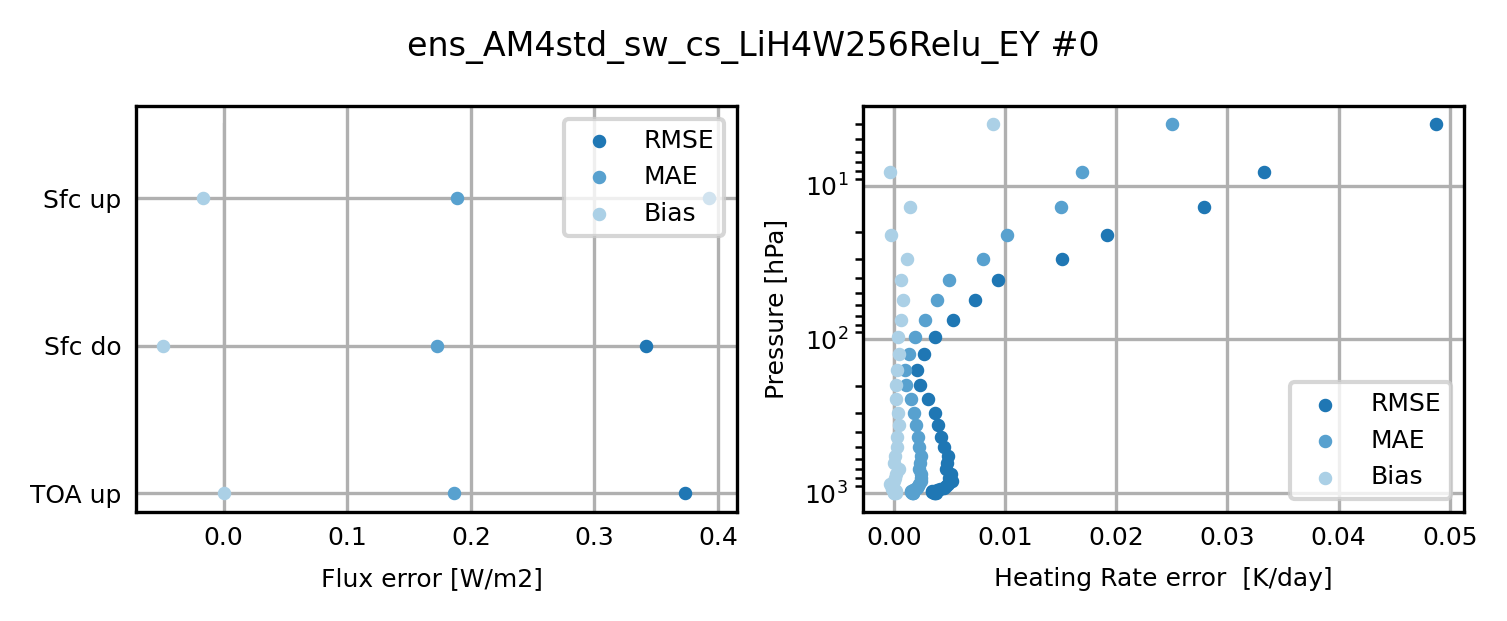

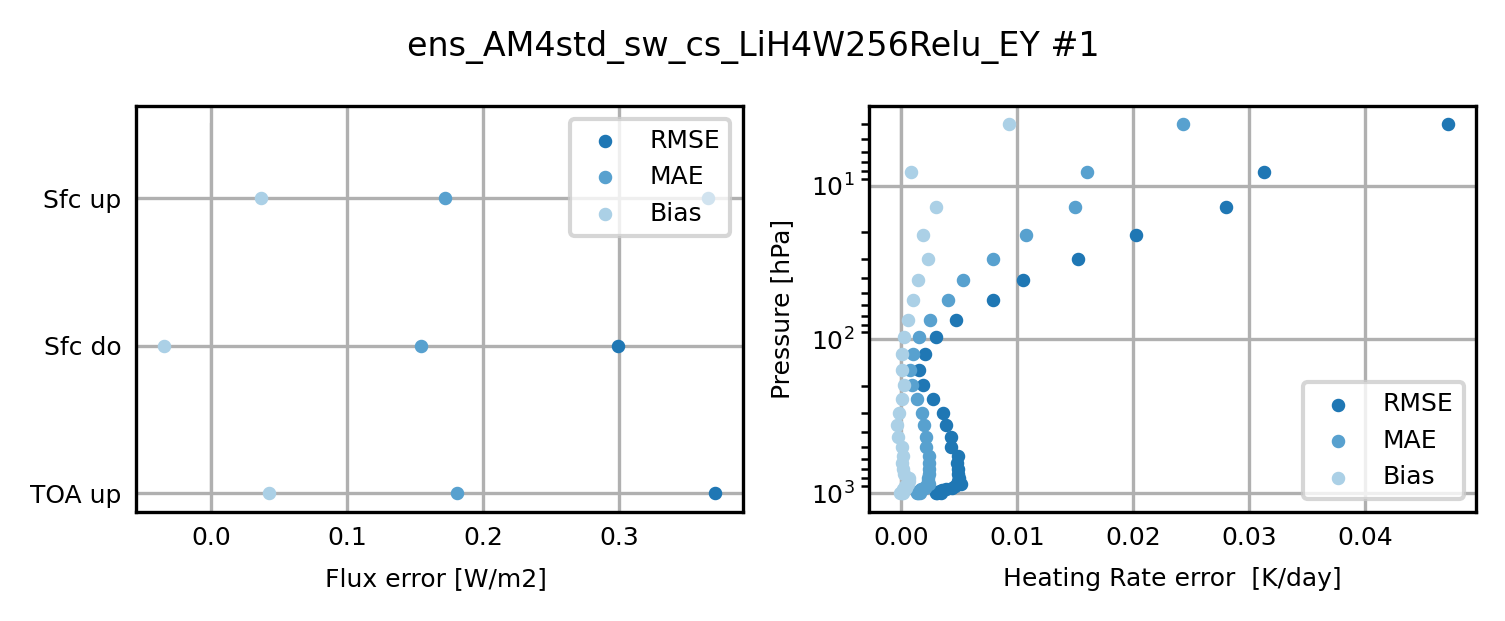

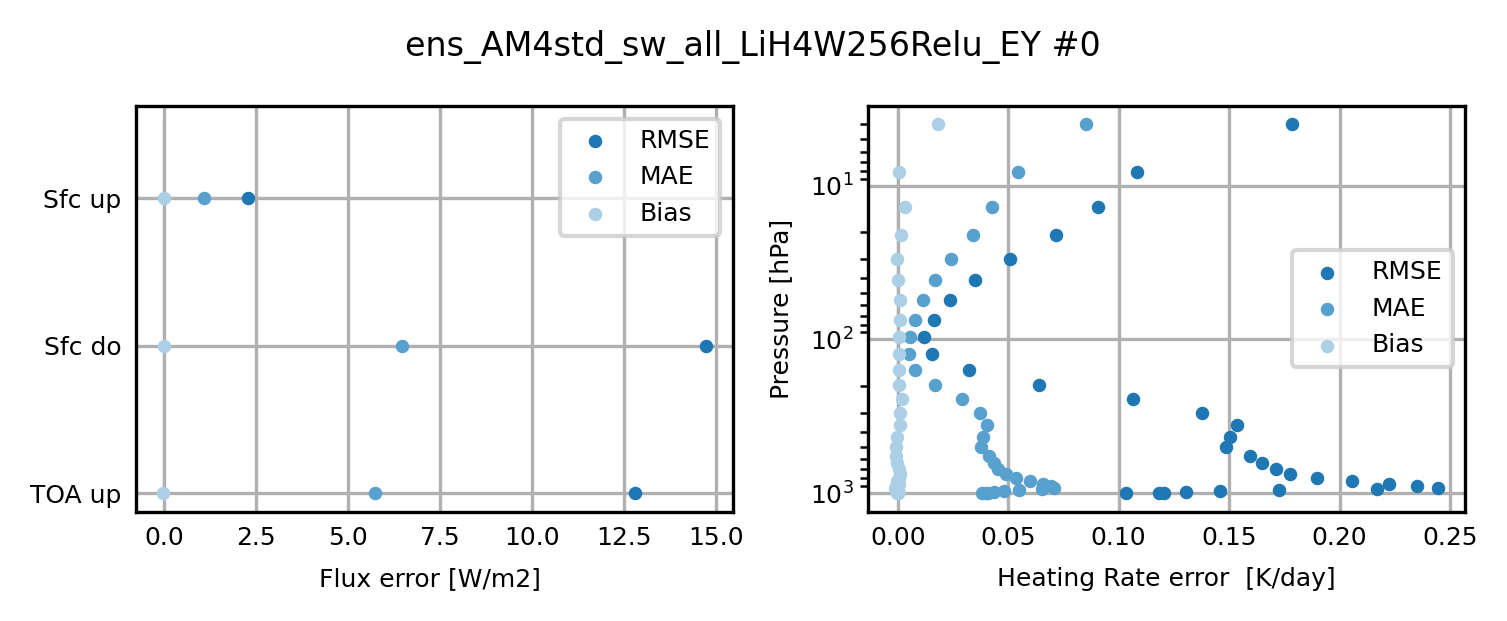

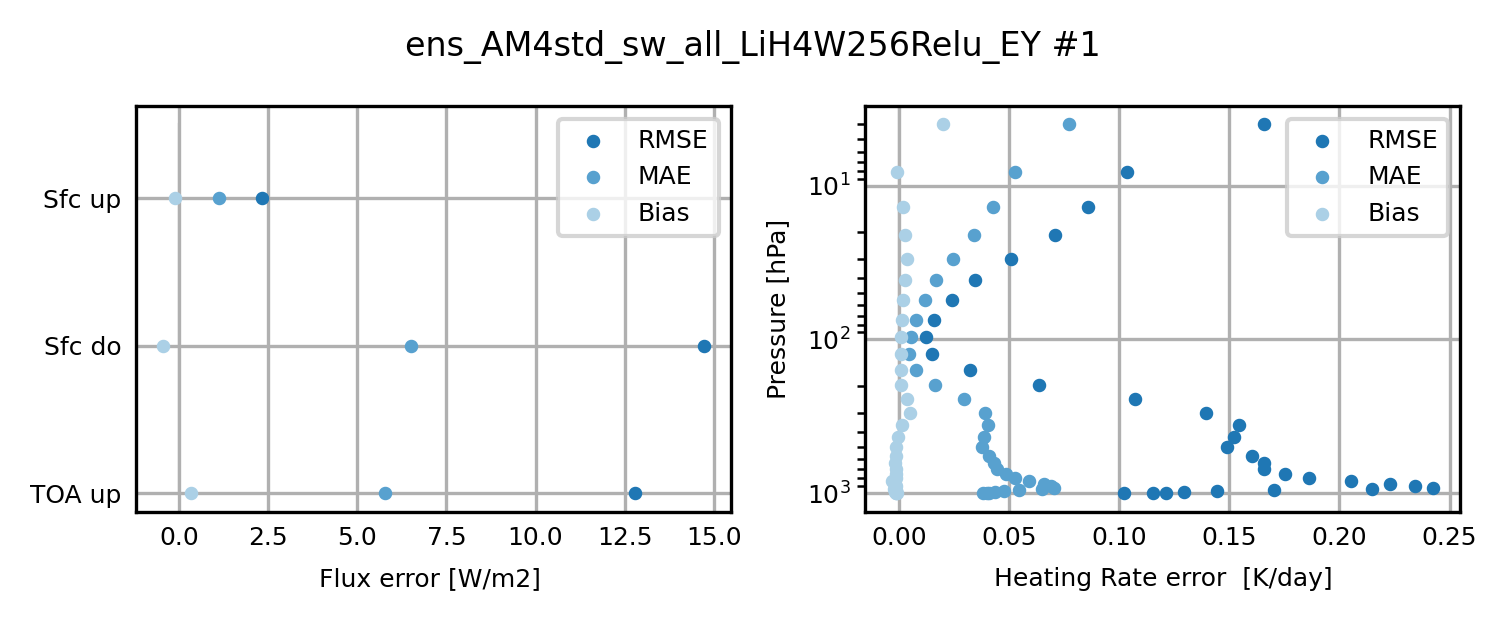

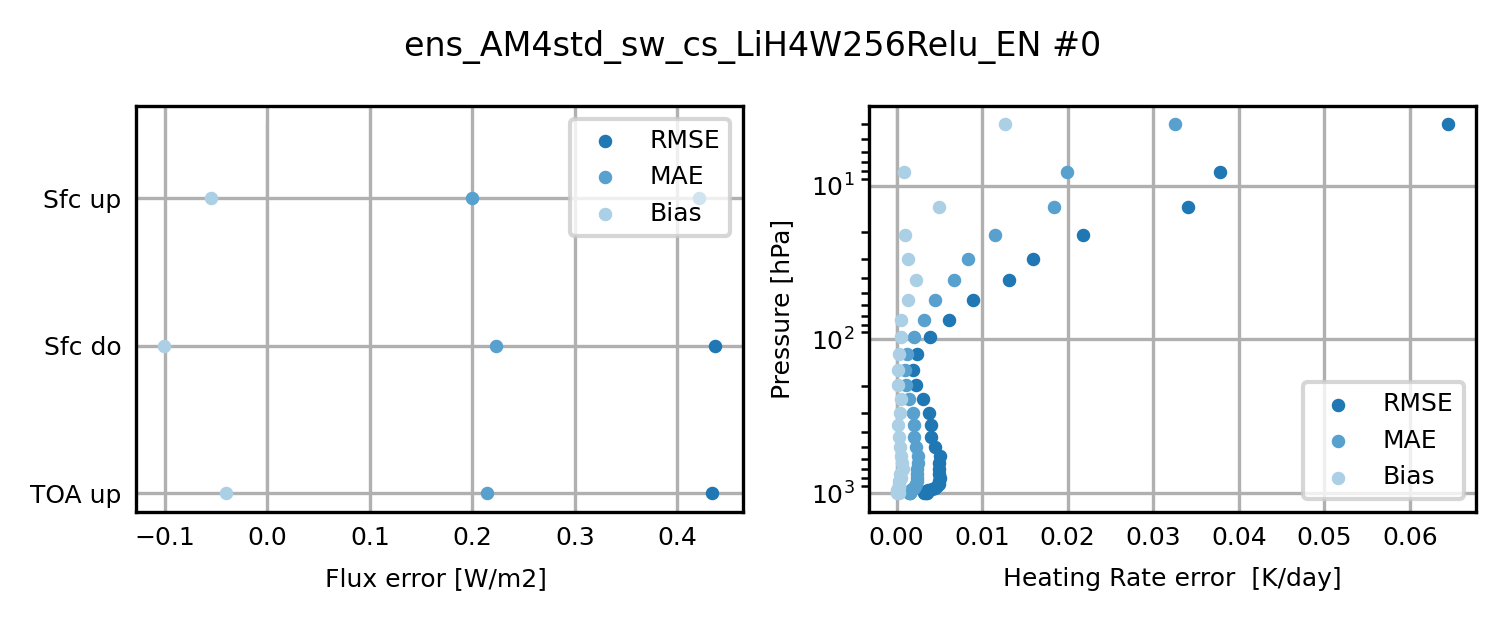

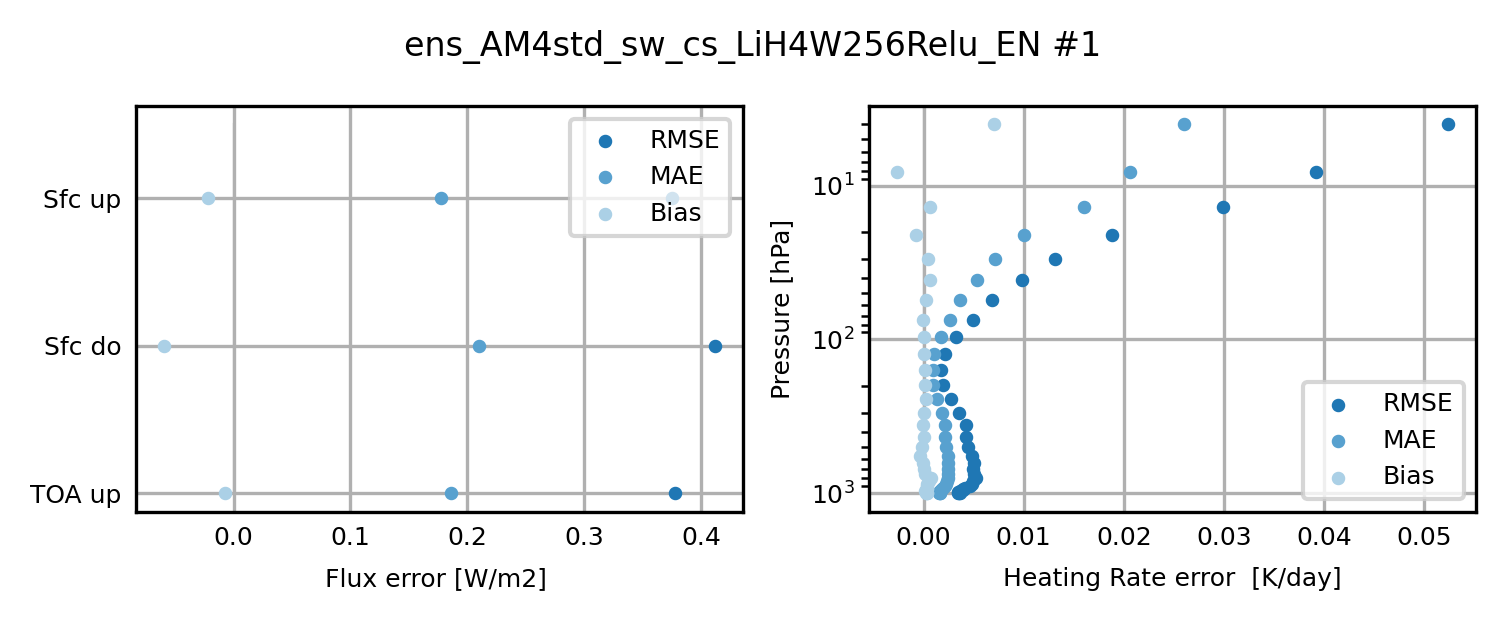

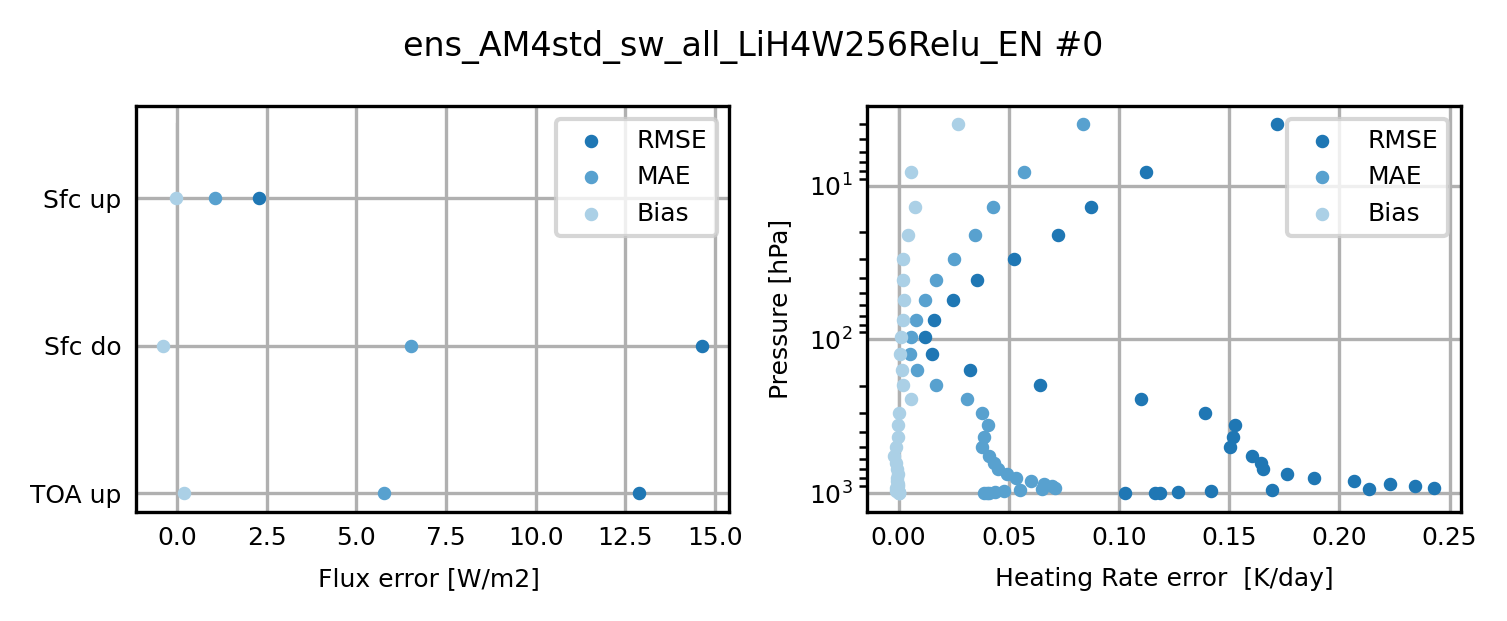

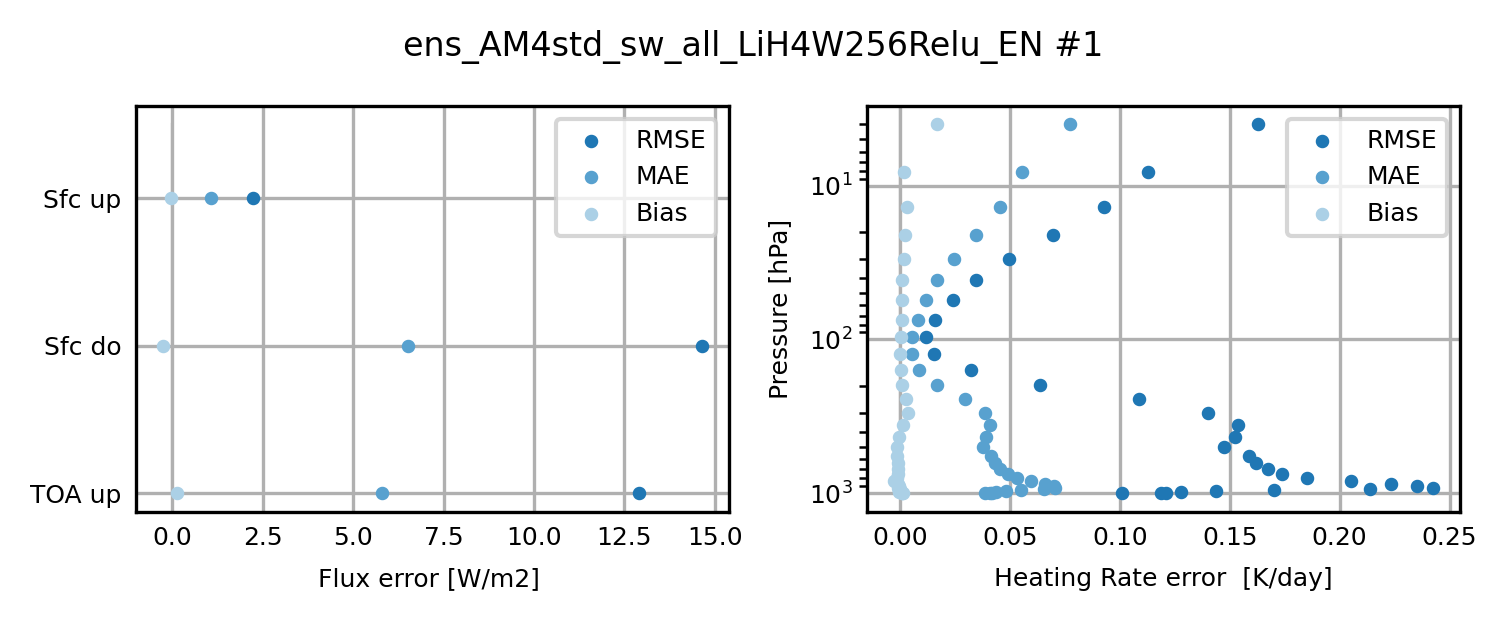

In [17]:
day_inds = {} 
for i, mo in enumerate(Exp_name): 
    for ei in range(ensemble_size): 
        RMSE = []
        MAE  = []
        Bias = []
        ds = ds_regrid[mo][ei]  
        rsut_nn = ds['rsut'].stack(txy=("time", "lat", "lon")).values
        rsut = rsut_nn-ds['err_rsut'].stack(txy=("time", "lat", "lon")).values
        day_ind = np.argwhere( ~np.isclose(rsut, 0, atol=1e-1)).squeeze() 
        day_inds[mo] = day_ind
        err_var = [ 'err_rsut','err_rsds','err_rsus','err_tntrs' ]  
        for i in range(len(err_var)): 
            da = ds[err_var[i]].mean('time')
            Bias.append(global_mean_xarray(da).values) 
            da = abs(ds[err_var[i]]).mean('time')
            MAE .append(global_mean_xarray(da).values) 
            da = ((ds[err_var[i]]**2).mean('time'))**0.5
            RMSE.append(global_mean_xarray(da).values) 
        plt.style.use('_mpl-gallery')
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5,2),dpi=300) 
        axs=axs.flatten() 
        ax3=axs[0] # error
        ax4=axs[1] # error 

        ax3.scatter(RMSE[:3], np.arange(3),  s=5, label='RMSE')
        ax3.scatter(MAE [:3], np.arange(3),  s=5, label='MAE')
        ax3.scatter(Bias[:3], np.arange(3),  s=5, label='Bias')
        ax3.plot([0,0],[0,2.5],c='k',linewidth = 0.5, zorder=0)
        ax3.set_yticks([0,1,2], labels=[ 'TOA up','Sfc do','Sfc up',])
        ax3.legend(fontsize=6)
        ax3.set_xlabel('Flux error [W/m2] ')
    #     ax3.set_xlim([-0.1,1.2])

        ax4.scatter(RMSE[3:]  , z_lev[1:],  s=5, label='RMSE')
        ax4.scatter(MAE [3:]  , z_lev[1:],  s=5, label='MAE') 
        ax4.scatter(Bias[3:]  , z_lev[1:],  s=5, label='Bias')
        ax4.plot([0,0],[0,1e3],c='k',linewidth = 0.5, zorder=0)
        ax4.legend(fontsize=6)
        ax4.invert_yaxis()
        ax4.set_yscale('log') 
    #     ax4.set_xlim([-0.04,0.4])
        ax4.set_xlabel('Heating Rate error  [K/day]')
        ax4.set_ylabel('Pressure [hPa]')
        plt.suptitle(f'{mo} #{ei}',fontsize=8)
        fig.tight_layout()
        fig.show()

# energy check

In [18]:
std_nor_vars_name  = [ 'rsut','rsds','rsus','tntrs' ]  
std_nor_vars_gn = {}
err_vars_name = ['err_eng', 'err_rsut','err_rsds','err_rsus','err_tntrs' ]  
err_vars_gn = {}  
for mo in Exp_name: 
    err_vars_gn[mo] = []
    std_nor_vars_gn[mo] = []
    for ei in range(ensemble_size):
        err_ei_dict = {}
        var_ei_dict = {}
        run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
        NN_output_name = f'NN_{ei}_20000101.fluxes_test' 
        for var in err_vars_name:
            err_ei_dict[var] = []
        for var in std_nor_vars_name:
            var_ei_dict[var] = []
        for ti in range(1,7):
            tile_file_path = exp_dir+f'/NN_pred/{NN_output_name}.tile{ti}.nc'
            print(tile_file_path)
            # open regridded file
            with  xr.open_dataset(tile_file_path) as ds:
                rsut_true = ds['rsut'].stack(txy=("time","grid_yt", "grid_xt")).values.T \
                          - ds['err_rsut'].stack(txy=("time","grid_yt", "grid_xt")).values.T
                day_ind = np.argwhere(~np.isclose(rsut_true,0, atol=1e-1)).squeeze()
                for var in err_vars_name: 
                    err_ei_dict[var].append(ds[var].stack(txy=("time","grid_yt", "grid_xt")).values.T[day_ind]) 
                for var in std_nor_vars_name:
                    var_ei_dict[var].append(ds[var].stack(txy=("time","grid_yt", "grid_xt")).values.T[day_ind]) 
        for var in err_vars_name:
            err_ei_dict[var] = np.concatenate(err_ei_dict[var]) 
        for var in std_nor_vars_name:
            var_ei_dict[var] = np.concatenate(var_ei_dict[var])
        err_vars_gn[mo].append(err_ei_dict)
        std = np.concatenate([np.atleast_1d(var_ei_dict[var].std(axis=0))  for var in std_nor_vars_name])
        std_nor_vars_gn[mo].append(std) 

/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/NN_pred/NN_0_20000101.fluxes_test.tile1.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/NN_pred/NN_0_20000101.fluxes_test.tile2.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/NN_pred/NN_0_20000101.fluxes_test.tile3.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/NN_pred/NN_0_20000101.fluxes_test.tile4.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/NN_pred/NN_0_20000101.fluxes_test.tile5.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/NN_pred/NN_0_20000101.fluxes_test.tile6.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/NN_pred/NN_1_20000101.fluxes_test.tile1.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/NN_pred/NN_1_20000101.fluxes_test.tile2.nc
/tigress/cw55/work/2022_radi_nn/work/ens_AM4std_sw_cs_LiH4W256Relu_EY/NN_pred/NN_1_20000101.flux

## exclude large energe error columns

In [19]:
for i, mo in enumerate(Exp_name): 
    for ei in range(ensemble_size): 
        err_eng_arr = err_vars_gn[mo][ei]['err_eng']
        ind_small_eng_err = np.argwhere(abs(err_eng_arr)<2)
        print(f"{mo} #{ei} good ratio: {ind_small_eng_err.size/err_eng_arr.size:4.2f}")
        rd_id_more = np.random.randint(0,ind_small_eng_err.shape[0],1000000) 
        ind_small_eng_err = ind_small_eng_err[rd_id_more] 
        err_var_arr = np.stack([err_vars_gn[mo][ei]['err_rsut'],
                                err_vars_gn[mo][ei]['err_rsds'],
                                err_vars_gn[mo][ei]['err_rsus']])
        RMSE = ((err_var_arr[:,ind_small_eng_err]**2).mean(axis=1)).squeeze()**0.5
        MAE  = abs(err_var_arr[:,ind_small_eng_err]).mean(axis=1).squeeze()
        Bias = err_var_arr[:,ind_small_eng_err].mean(axis=1).squeeze()
        print('filtered',Bias[:2],MAE[:2],RMSE[:2])
        rd_id_more = np.random.randint(0,err_eng_arr.shape[0],1000000) 
        RMSE = ((err_var_arr[:,rd_id_more]**2).mean(axis=1))**0.5
        MAE  = abs(err_var_arr[:,rd_id_more]).mean(axis=1)
        Bias = err_var_arr[:,rd_id_more].mean(axis=1)
        print('raw     ',Bias[:2],MAE[:2],RMSE[:2])

ens_AM4std_sw_cs_LiH4W256Relu_EY #0 good ratio: 1.00
filtered [ 0.00893796 -0.06467562] [0.33386478 0.29296046] [0.6134022 0.6002326]
raw      [ 0.00915026 -0.06365556] [0.33424345 0.29307592] [0.6166601 0.5992494]
ens_AM4std_sw_cs_LiH4W256Relu_EY #1 good ratio: 1.00
filtered [ 0.07302494 -0.05326273] [0.31928658 0.26400638] [0.5880092  0.46279857]
raw      [ 0.07166292 -0.05319171] [0.3210041  0.26491332] [0.61062294 0.46694818]
ens_AM4std_sw_all_LiH4W256Relu_EY #0 good ratio: 1.00
filtered [-0.07490988  0.06894071] [14.415631 16.258904] [27.976309 31.510555]
raw      [-0.04402795  0.0240192 ] [14.459075 16.324108] [28.039719 31.604347]
ens_AM4std_sw_all_LiH4W256Relu_EY #1 good ratio: 1.00
filtered [ 0.5608798 -0.7155138] [14.442409 16.323505] [27.874247 31.43695 ]
raw      [ 0.53637326 -0.70892876] [14.48256  16.367287] [27.945301 31.501991]
ens_AM4std_sw_cs_LiH4W256Relu_EN #0 good ratio: 0.99
filtered [-0.03487138 -0.14533837] [0.34688693 0.35736933] [0.851291  0.6470159]
raw      [

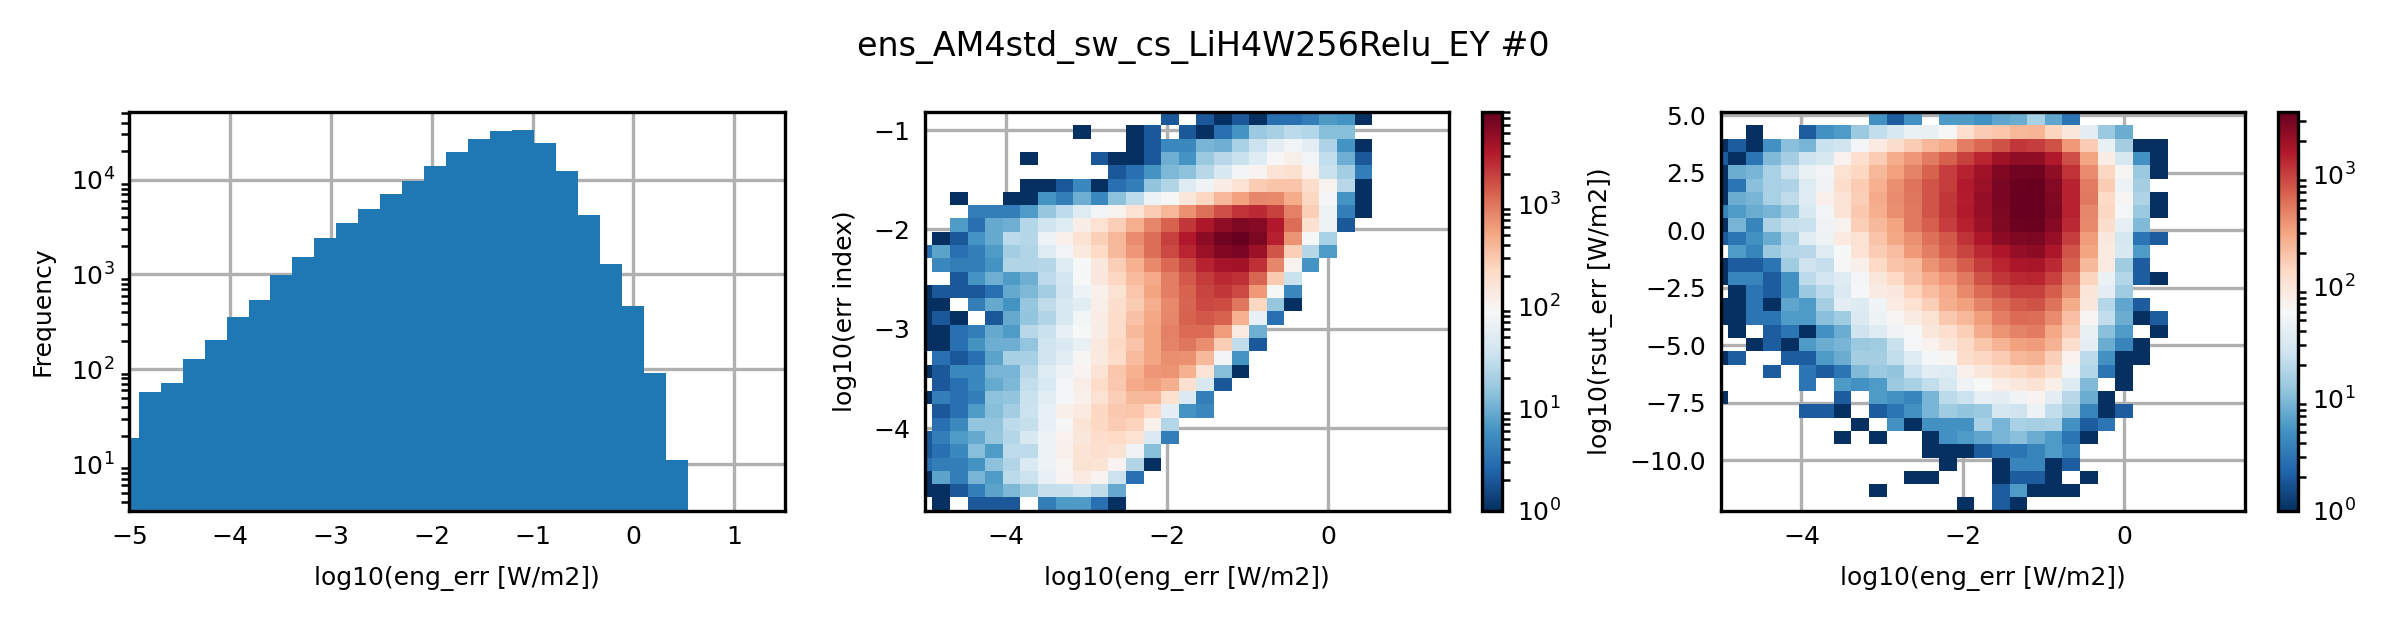

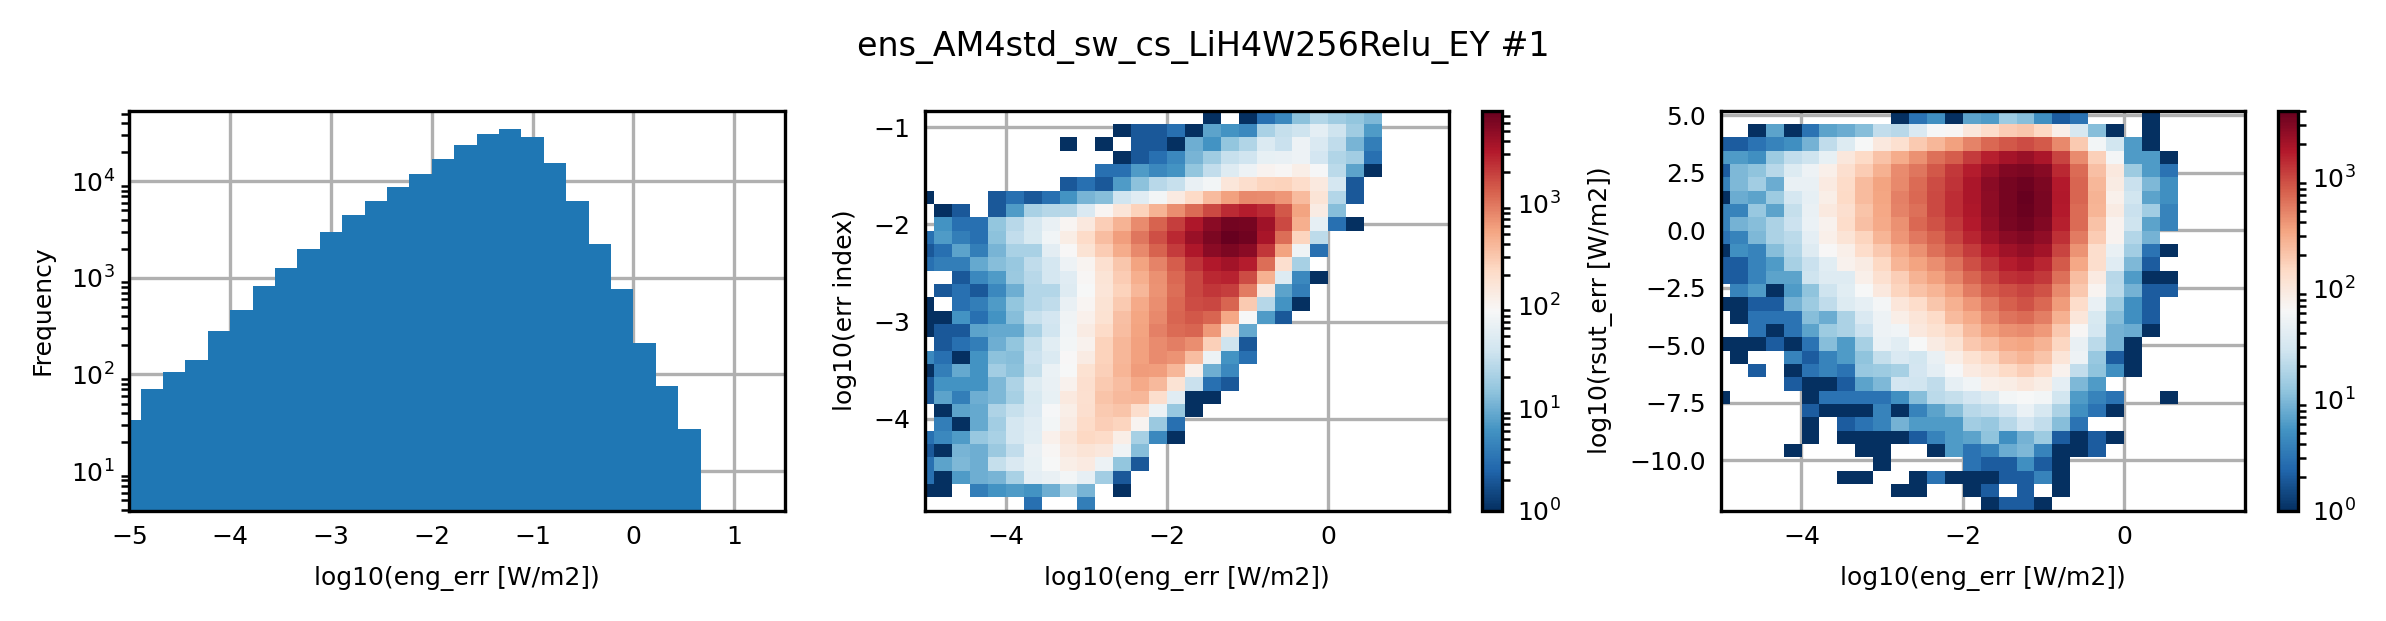

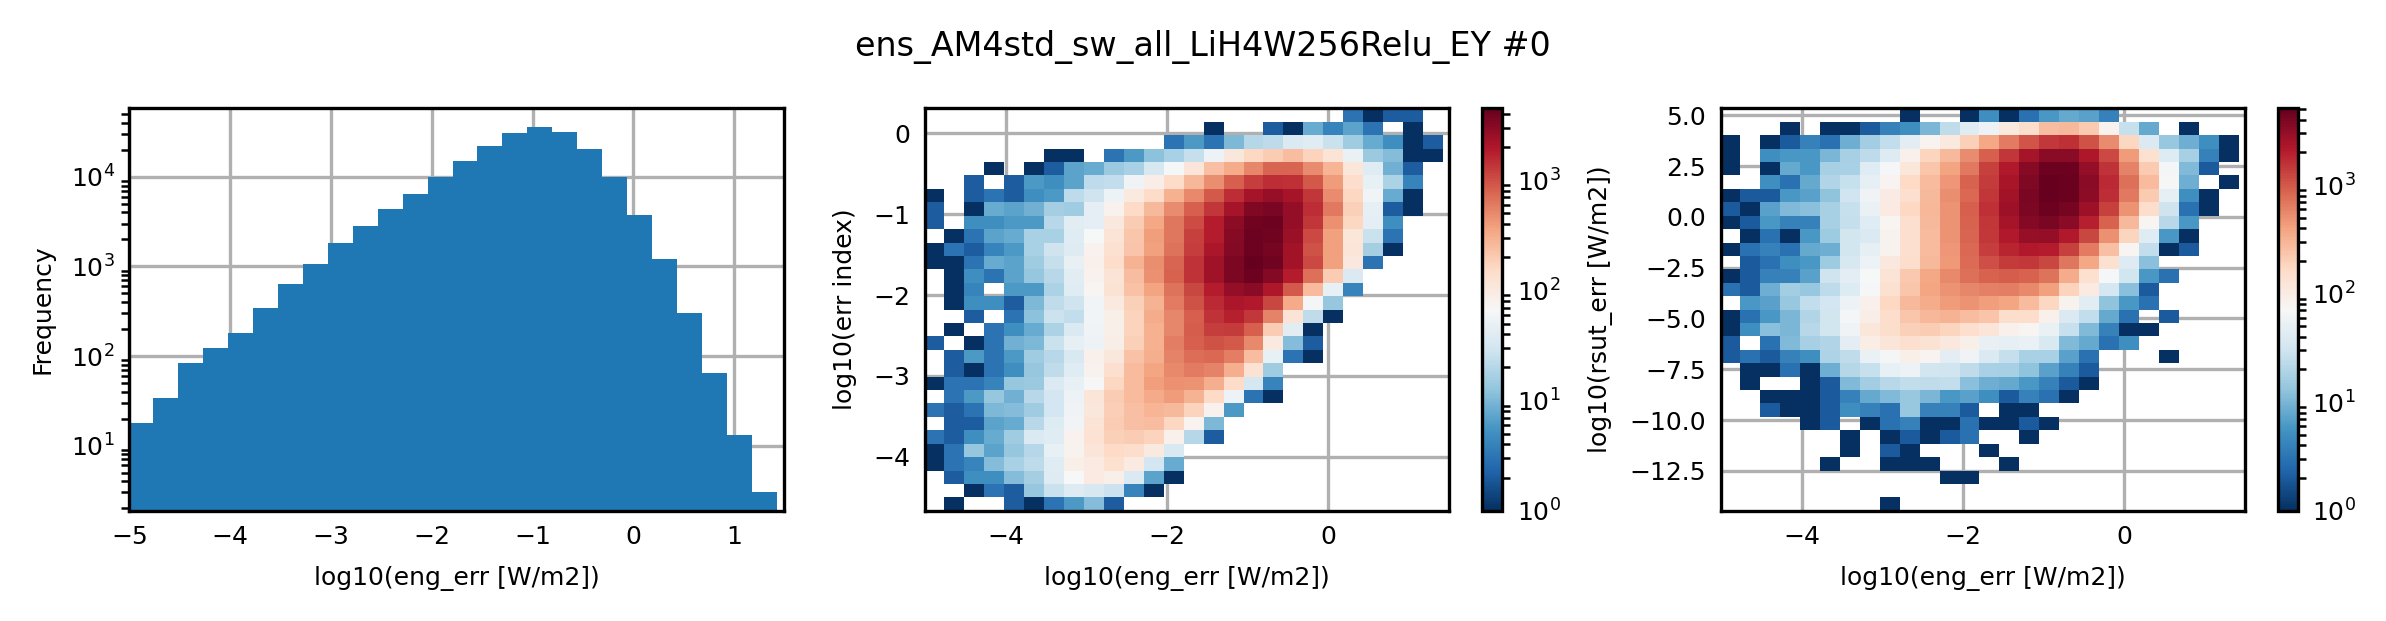

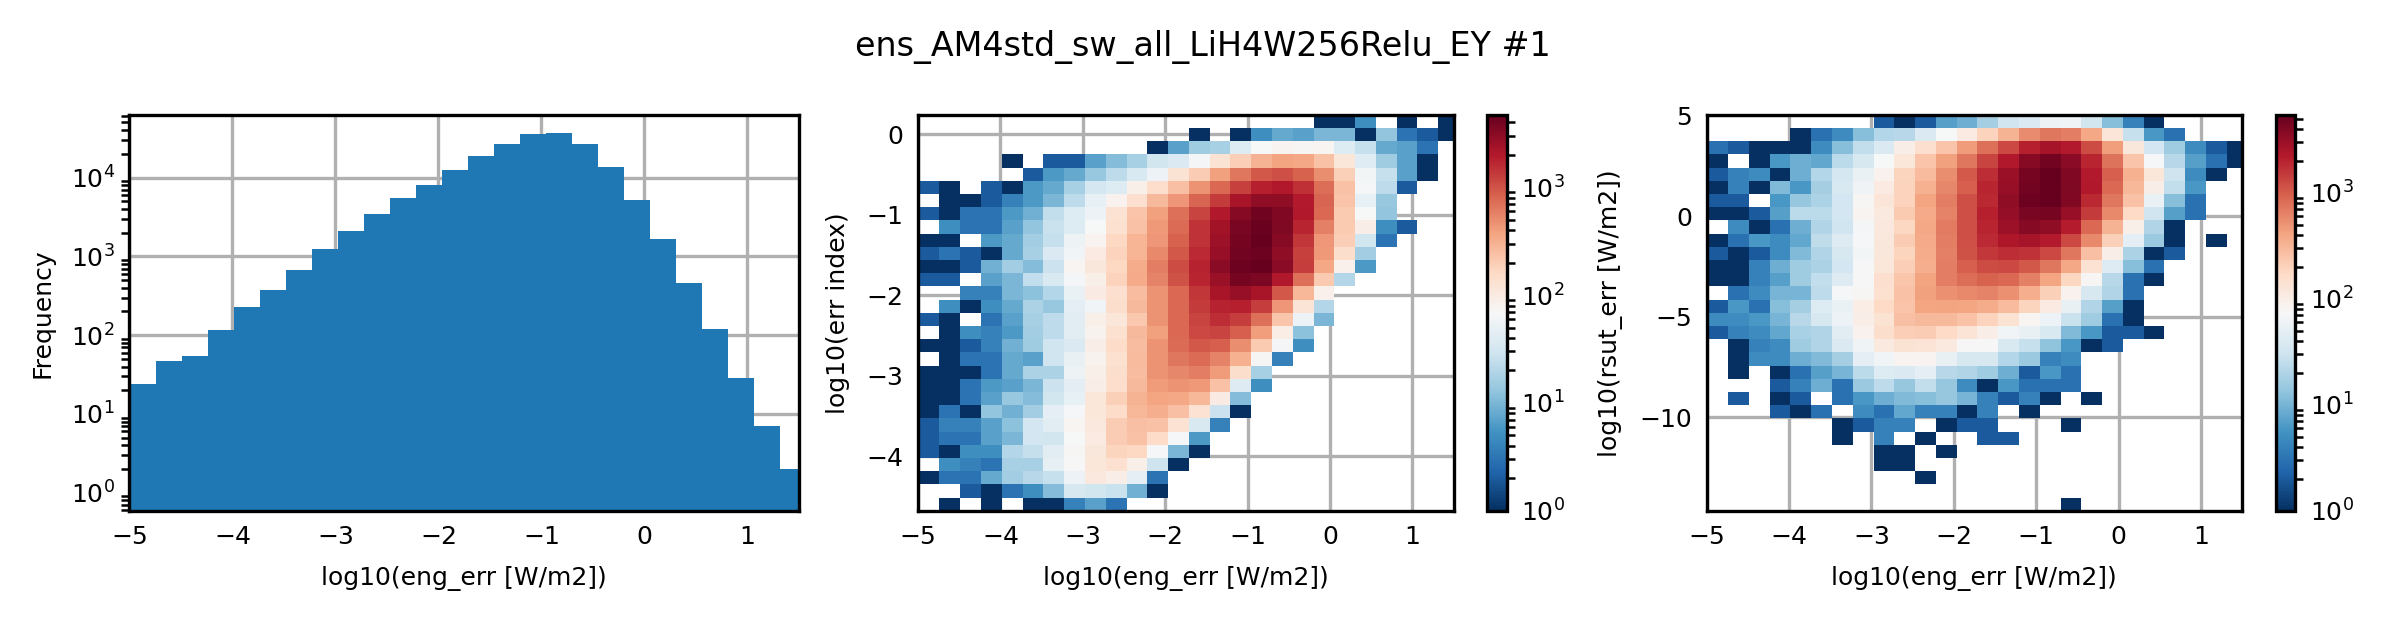

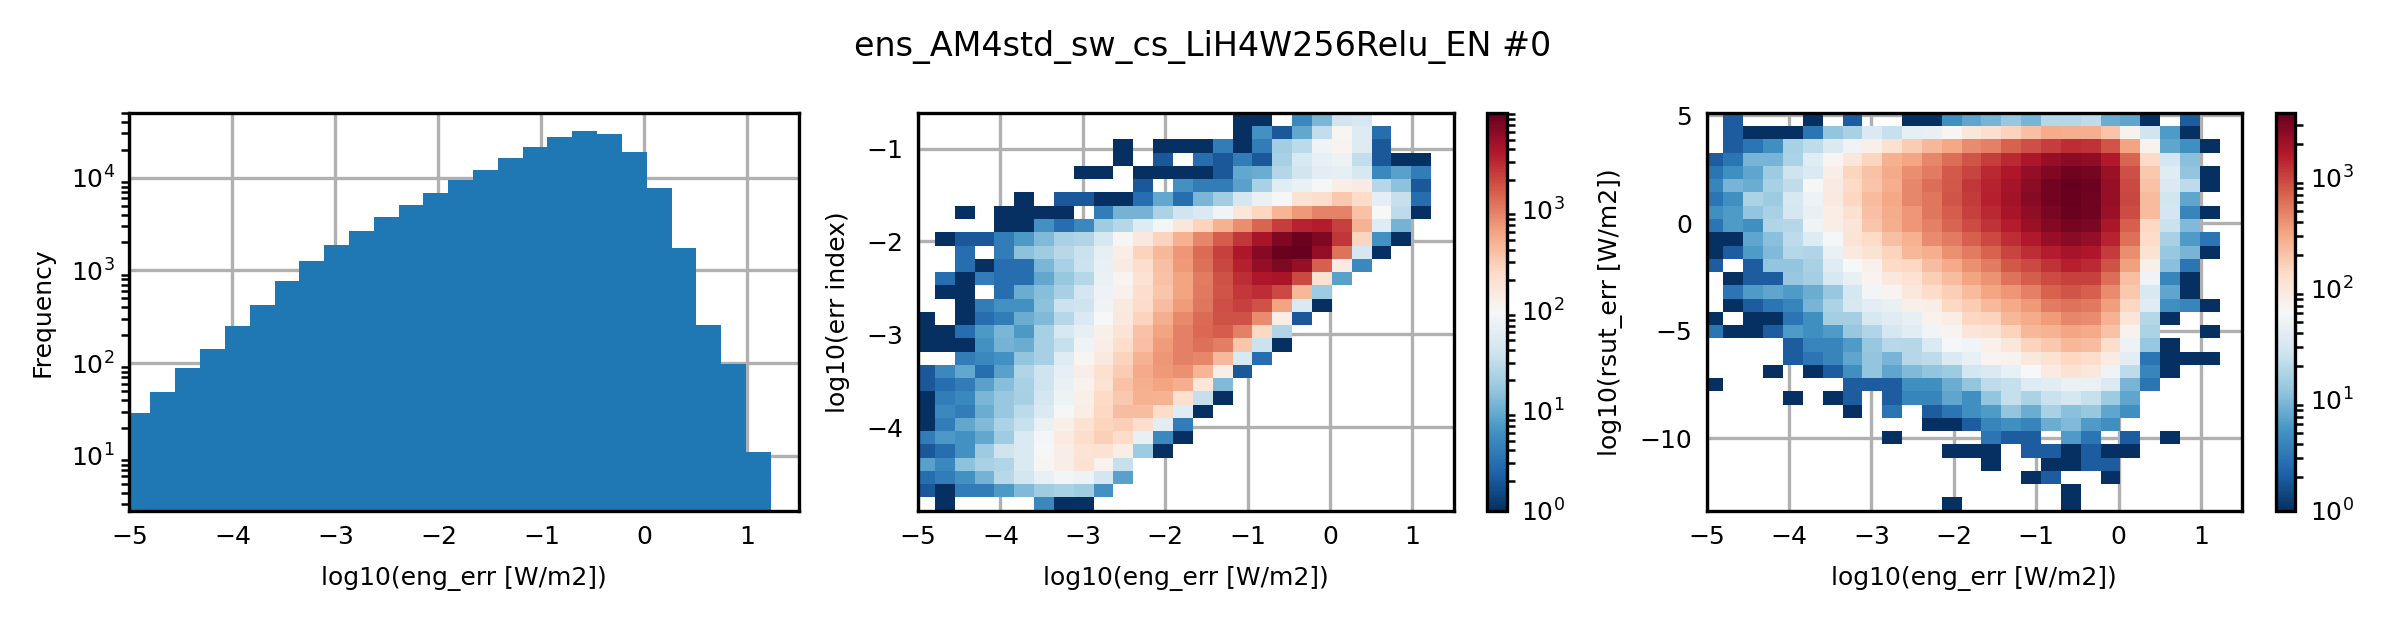

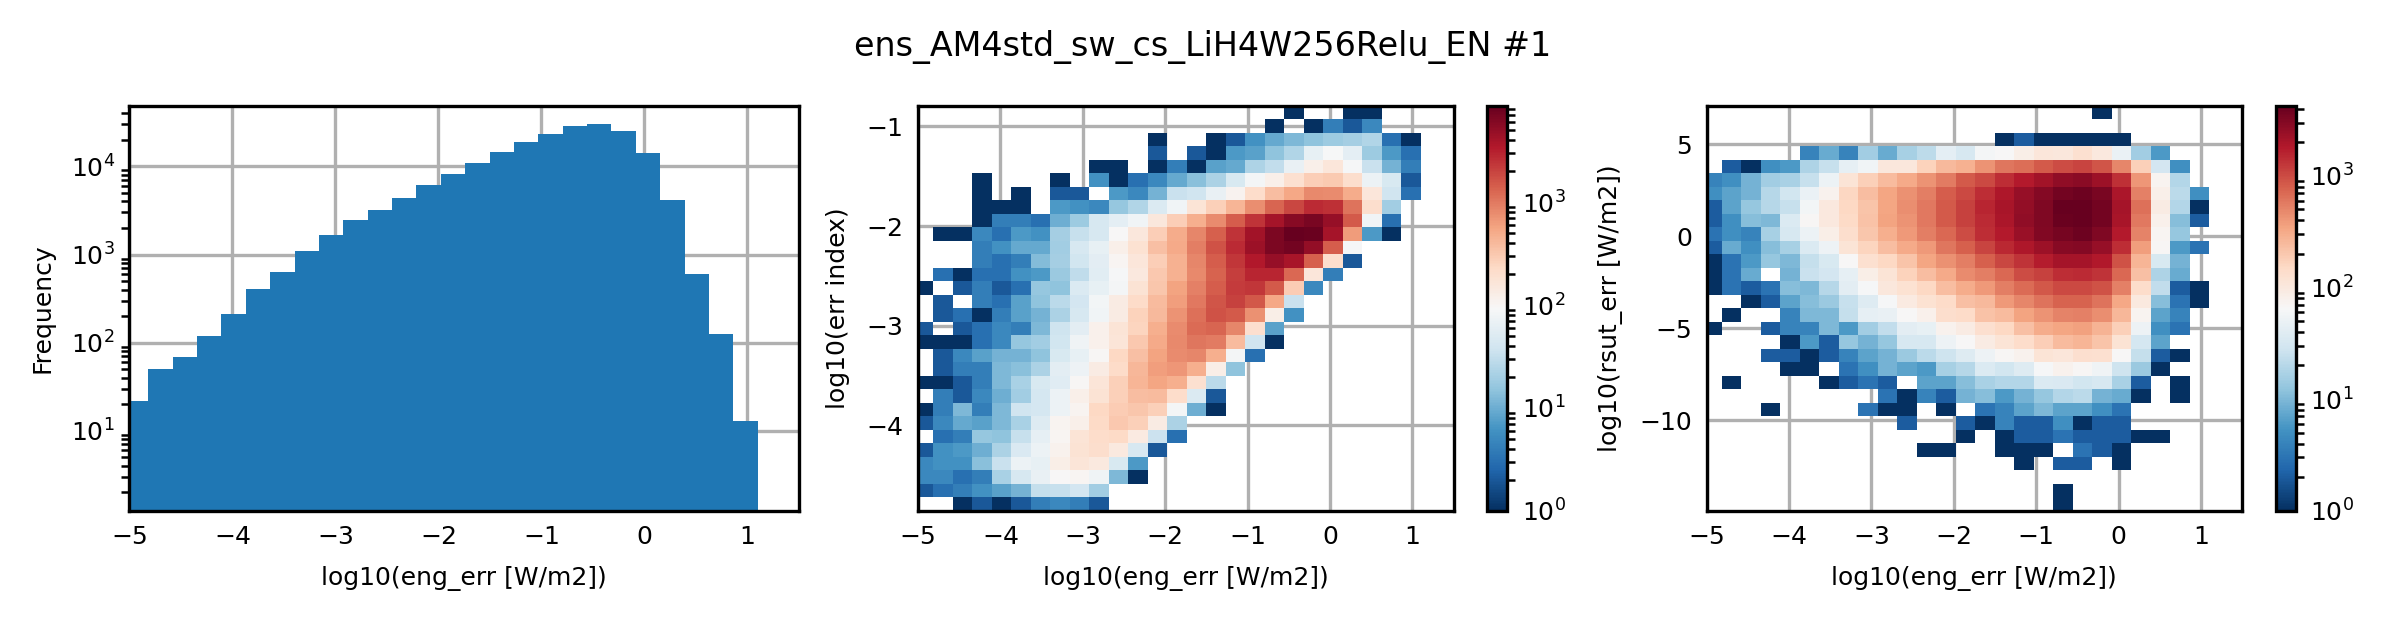

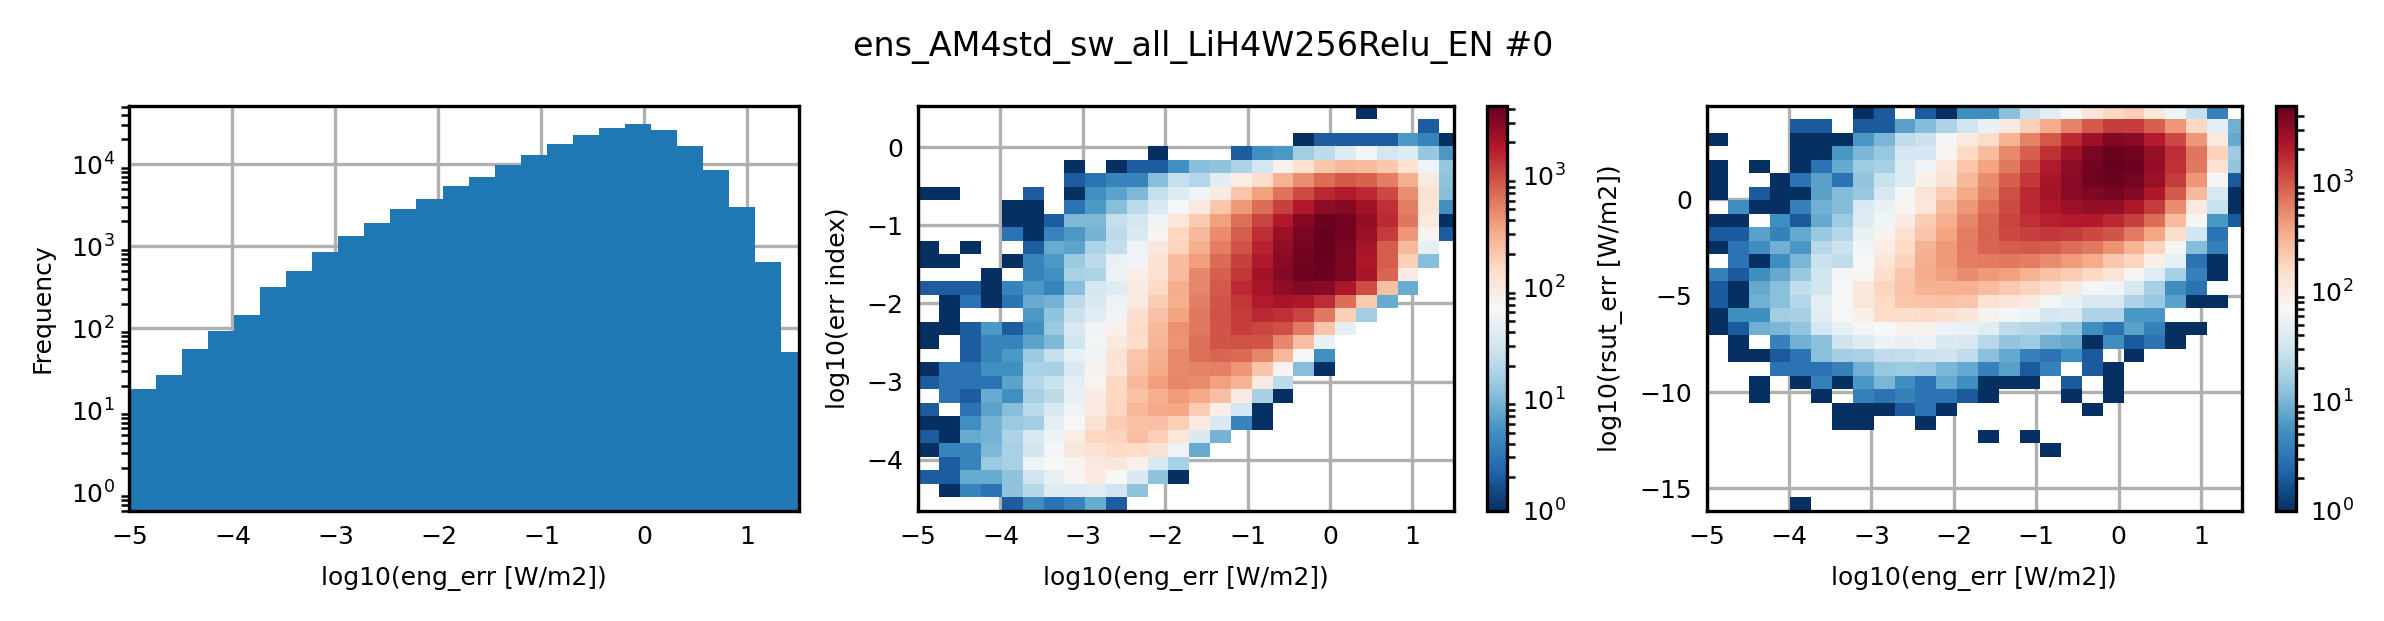

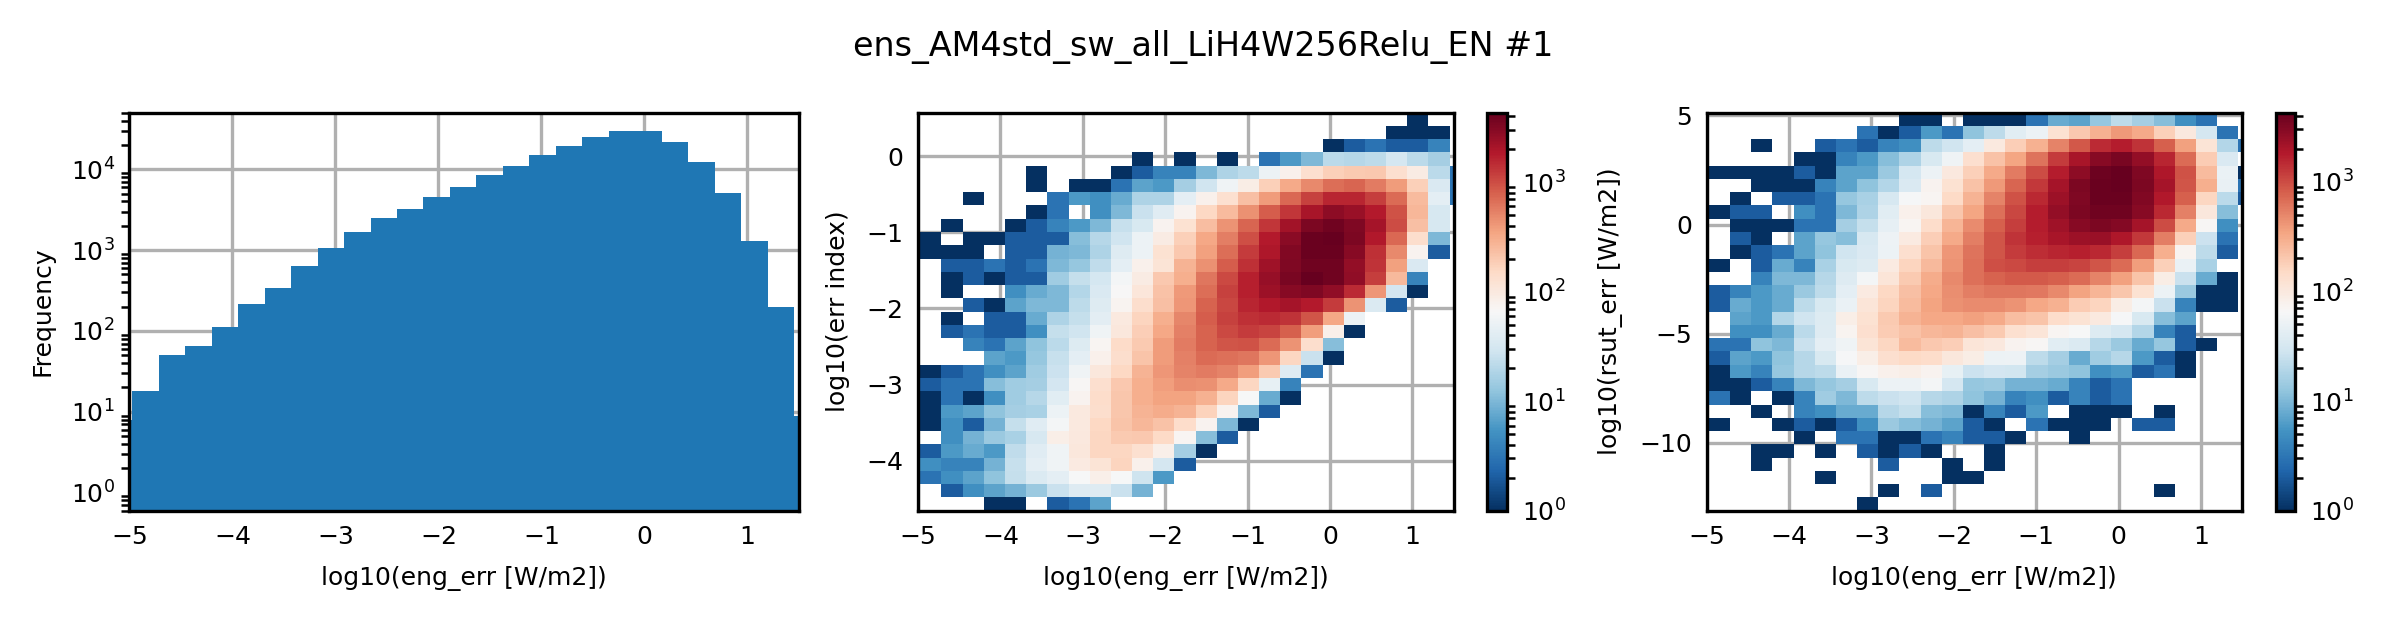

In [20]:
for i, mo in enumerate(Exp_name):  
    for ei in range(ensemble_size):
        err_eng_arr = err_vars_gn[mo][ei]['err_eng']  

        std_nor = std_nor_vars_gn[mo][ei]
        err_var_all = np.concatenate([np.atleast_2d(err_vars_gn[mo][ei][var].T)  for var in err_vars_name[1:]],axis=0)
        pred_err_ind = abs(err_var_all/std_nor[:,None]).mean(axis=0)
        
        rd_id_more = np.random.randint(0,err_eng_arr.size,200000)
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,2),dpi=300, tight_layout=True) 
        axs= axs.flatten()
        ax = axs[0]
        eng_err_log = np.log(abs(err_eng_arr[rd_id_more])+1e-6)/np.log(10)
        pred_err_ind_log = np.log(abs(pred_err_ind[rd_id_more])+1e-6)/np.log(10)
        ax.hist(eng_err_log,bins=30)
        ax.set_yscale('log')
        ax.set_xlim([-5,1.5])
        ax.set_xlabel('log10(eng_err [W/m2])')
        ax.set_ylabel('Frequency')
        ax = axs[1]
        h=ax.hist2d(eng_err_log,pred_err_ind_log, bins=30,
                    norm=colors.LogNorm(),
                    cmap='RdBu_r') 
        fig.colorbar(h[3], ax=ax)
        ax.set_xlim([-5,1.5])
        ax.set_xlabel('log10(eng_err [W/m2])')
        ax.set_ylabel('log10(err index)')
        ax = axs[2]
        h=ax.hist2d(eng_err_log,np.log(abs(err_var_arr[0,rd_id_more]+1e-6)/np.log(10)),
                   bins=30, 
                    norm=colors.LogNorm(),
                    cmap='RdBu_r') 
        fig.colorbar(h[3], ax=ax)
        ax.set_xlim([-5,1.5])
        ax.set_xlabel('log10(eng_err [W/m2])')
        ax.set_ylabel('log10(rsut_err [W/m2])')
        plt.suptitle(f'{mo} #{ei}',fontsize=8) 
        fig.show()